# To do
1. Do Train validation test splits, use hyperparameter tuning on the train
3. run and report the result
Fix the AUPRC estimation (done)
implement nested CV for CV and hyperparameter tuning (done)
# Questions

In [49]:
import pandas as pd
import pickle
import numpy as np
import time
import os
import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

from skopt import BayesSearchCV
import skopt.space


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
#import xgboost


from sklearn.metrics import classification_report,precision_recall_curve,confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer,roc_curve, auc, plot_roc_curve, plot_precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn import svm

import scipy.stats

#import umap


import seaborn as sns
import matplotlib.pyplot as plt

#import tensorflow as tf
#from tensorflow import keras
#from tensorboard.plugins import projector
#import keras_tuner as kt



from tqdm import tqdm, tqdm_notebook
#import IPython
#%matplotlib widget

In [50]:
def load_obj(name ):
    with open('obj_' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [51]:
# Pandas settings
pd.set_option("display.max_rows", 100) 
pd.set_option("display.max_columns", 100) 
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.latex.longtable', True)
pd.DataFrame._repr_latex_ = lambda self: r"\begin{footnotesize}\centering{%s}\end{footnotesize}" % self.to_latex()

# 1. Import and combine data

In [52]:
filenames_input=['Anthropometrics and cardiac risk factors.csv',
                 'Baseline Medical Conditions.csv',
                 'Early life factors.csv',
                 'Home locations.csv',
                 'Pollutants.csv',
                 'sociodem_socioeco.csv',
                 'summary_diagnoses.csv']
path=r'/home/mo/Env_vars_DL/tidy_data_tiles/'

In [53]:
selected_categories_exclusions=load_obj('selected_categories_exclusions')
selected_categories_tidy_columns=load_obj('selected_categories_tidy_columns')
selected_categories_tidy=load_obj('selected_categories_tidy')

selected_outcome_categories_exclusions=load_obj('selected_outcome_categories_exclusions')
selected_outcome_categories_tidy_columns=load_obj('selected_outcome_categories_tidy_columns')
selected_outcome_categories_tidy=load_obj('selected_outcome_categories_tidy')

In [54]:
df_input=pd.DataFrame()
for filename in filenames_input:
    if filename=='summary_diagnoses.csv':
        df_temp=pd.read_csv(path+filename,index_col='Unnamed: 0')
        df_temp.fillna('1',inplace=True)
        df_temp[df_temp!='1']=1
        df_temp[df_temp=='1']=0
    else:
        df_temp=pd.read_csv(path+filename,index_col='Unnamed: 0')
    df_input=pd.concat([df_input,df_temp],axis=1)
df_label=pd.read_csv(path+'Outcomes.csv',index_col='Unnamed: 0')

/home/mo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,50,52,54,55,56,57,61,62,67,68,69,70,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,96,97,98,100,101,103,104,106,108,109,110,111,112,115,116,117,118,119,120,121,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,162,163,164,165,166,169,171,172,173,174,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,194,195,196,197,198,200,201,202,203,204,207,208,209,211,212,213,215,216,218,219,220,221,222,223,224,225,226,227,228,229,230,231,233,236,238,240,241,242,243,244,245,249,250,251,252,253,254,256,257,259,260,261,262,264,265,266,267,269,270,272,273,274,275,276,279,280,283,284,285,286,287,290,291,292,293,294,295,296,297,298,299,300,301,302,303,30

In [55]:
selected_categories_tidy_columns["41270"]["type"]="binary"

## 1.1 column to variable dict

In [56]:
#rename_cols_names_dict={v['col_name'][0]:k for k,v in selected_categories_tidy_columns.items() if len(v['col_name'])==1}
#df_input.rename(columns=rename_cols_names_dict,inplace=True)

In [57]:
#for k,v in rename_cols_names_dict.items():
#    selected_categories_tidy_columns[v]['col_name']=[v]    

In [58]:
column_to_var_dict=dict()
for k,v in selected_categories_tidy_columns.items():
    for col in v['col_name']:
        column_to_var_dict[col]=[k,v['type']]
        
#column_to_var_dict

# 2. convert dtype and impute

In [59]:
#df_input.rename(columns={"129":'Place of birth in UK - north co-ordinate',"130":'Place of birth in UK - east co-ordinate',"20115": 'Country of Birth',"20022":'Birth weight'},
#                inplace=True)


#column_to_var_dict['Place of birth in UK - north co-ordinate']=['Place of birth in UK - north co-ordinate','int']
#column_to_var_dict['Place of birth in UK - east co-ordinate']=['Place of birth in UK - east co-ordinate','int']
#column_to_var_dict['Birth weight']=['Birth weight','float']
#column_to_var_dict['Country of Birth']=['Country of Birth','int']
column_to_var_dict['130-0.0']

['Place of birth in UK - east co-ordinate', 'int']

In [60]:
for variable in selected_categories_tidy_columns.keys():
    print('Converting column:'+variable+' to dtype *'+selected_categories_tidy_columns[variable]["type"])


Converting column:gender to dtype *binary
Converting column:birth_date to dtype *date
Converting column:Townsend deprivation index at recruitment to dtype *float
Converting column:Age at recruitment to dtype *int
Converting column:Ethnicity to dtype *binary
Converting column:Household Income to dtype *binary
Converting column:Current employment status to dtype *binary
Converting column:Qualifications to dtype *binary
Converting column:Standing height to dtype *int
Converting column:BMI to dtype *float
Converting column:SBP to dtype *int
Converting column:DBP to dtype *int
Converting column:PR to dtype *int
Converting column:Alcohol Status to dtype *binary
Converting column:Smoking Status to dtype *binary
Converting column:Baseline Medical conditions to dtype *binary
Converting column:Home location at assessment to dtype *int
Converting column:Home area population density to dtype *int
Converting column:24003: Nitrogen dioxide air pollution; 2010 to dtype *float
Converting column:24004:

In [61]:
df_input_impt=df_input.copy()
cols_with_na=df_input.loc[:,df_input.iloc[:,:].isna().sum()>0].columns.values

imp_strtgy={'int':'mean','float':'mean','binary':'constant'}
for col in cols_with_na:
    print(column_to_var_dict[col])
    imp = SimpleImputer(missing_values=np.nan,fill_value=0, strategy=imp_strtgy[column_to_var_dict[col][1]])
    X=df_input_impt[col].to_numpy().reshape(-1, 1)
    imp.fit(X)
    df_input_impt[col]=imp.transform(X)    

['Standing height', 'int']
['BMI', 'float']
['Place of birth in UK - north co-ordinate', 'int']
['Place of birth in UK - east co-ordinate', 'int']
['Country of Birth', 'int']
['Birth weight', 'float']
['Home location at assessment', 'int']
['Home location at assessment', 'int']
['Home area population density', 'int']
['24005: Particulate matter air pollution (pm10); 2010', 'float']
['24003: Nitrogen dioxide air pollution; 2010', 'float']
['24007: Particulate matter air pollution (pm2.5) absorbance; 2010', 'float']
['24004: Nitrogen oxides air pollution; 2010', 'float']
['24006: Particulate matter air pollution (pm2.5); 2010', 'float']
['24008: Particulate matter air pollution 2.5-10um; 2010', 'float']
['24011: Traffic intensity on the nearest major road', 'int']
['24010: Inverse distance to the nearest road', 'float']
['24012: Inverse distance to the nearest major road', 'float']
['24013: Total traffic load on major roads', 'int']
['24015: Sum of road length of major roads within 100m'

# 2. Modelling

# 2. Preps

In [62]:
df_input_impt.loc[:,~df_input_impt.columns.isin(selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]+list(selected_categories_tidy_columns["41270"]["col_name"]))].head()

,50-0.0,21001-0.0,SBP_avg,DBP_avg,PR_avg,Alcohol Status_Current,Alcohol Status_Never,Alcohol Status_Prefer not to answer,Alcohol Status_Previous,Smoking Status_Current,Smoking Status_Never,Smoking Status_Prefer not to answer,Smoking Status_Previous,myasthenia gravis.1,129-0.0,130-0.0,20115-0.0,20022-0.0,Exclude_Home_location,Home_Longitude,Home_Latitude,20118-0.0,24005-0.0,24003-0.0,24007-0.0,24004-0.0,24006-0.0,24008-0.0,24011-0.0,24014-0.0,24010-0.0,24012-0.0,24013-0.0,24015-0.0,24009-0.0,189-0.0,21022-0.0,31-0.0,birth_date,Ethnicity_African,Ethnicity_Any other Asian background,Ethnicity_Any other Black background,Ethnicity_Any other mixed background,Ethnicity_Any other white background,Ethnicity_Asian or Asian British,Ethnicity_Bangladeshi,Ethnicity_Black or Black British,Ethnicity_British,Ethnicity_Caribbean,Ethnicity_Chinese,Ethnicity_Do not know,Ethnicity_Indian,Ethnicity_Irish,Ethnicity_Mixed,Ethnicity_Other ethnic group,Ethnicity_Pakistani,Ethnicity_Prefer not to answer,Ethnicity_White,Ethnicity_White and Asian,Ethnicity_White and Black African,Ethnicity_White and Black Caribbean,"Household_inc_18,000 to 30,999","Household_inc_31,000 to 51,999","Household_inc_52,000 to 100,000",Household_inc_Do not know,"Household_inc_Greater than 100,000","Household_inc_Less than 18,000",Household_inc_Prefer not to answer,Employment_Doing unpaid or voluntary work,Employment_Full or part-time student,Employment_In paid employment or self-employed,Employment_Looking after home and/or family,Employment_None of the above,Employment_Prefer not to answer,Employment_Retired,Employment_Unable to work because of sickness or disability,Employment_Unemployed,Qualifications_A levels/AS levels or equivalent,Qualifications_CSEs or equivalent,Qualifications_College or University degree,Qualifications_NVQ or HND or HNC or equivalent,Qualifications_None of the above,Qualifications_O levels/GCSEs or equivalent,"Qualifications_Other professional qualifications eg: nursing, teaching",Qualifications_Prefer not to answer
0,154.0,29.9798,136,75,82,1,0,0,0,0,0,0,1,0,405500.0,373500.0,257.309766,3.319041,False,340000.0,388000.0,5.0,14.48,31.57,1.23,53.83,10.40,5.68,15763.0,0,0.04,0.00226,0.0,0.0,500.0,-0.953776,62,0,1947-02-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,174.0,24.4088,124,78,66,1,0,0,0,0,0,0,1,0,172500.0,541500.0,257.309766,3.319041,False,337000.0,388000.0,5.0,15.93,29.36,1.26,45.93,9.96,6.02,14247.0,0,0.04,0.00549,0.0,0.0,500.0,5.116970,56,0,1952-12-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,166.0,29.3584,119,76,58,1,0,0,0,0,1,0,0,0,101500.0,472500.0,257.309766,3.319041,True,524000.0,168000.0,5.0,16.84,29.68,1.30,46.93,9.27,6.42,26109.0,0,0.03,0.00094,0.0,0.0,500.0,-2.322980,49,0,1960-10-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,179.0,30.6170,170,107,56,1,0,0,0,0,1,0,0,0,398500.0,383500.0,257.309766,3.290000,False,512000.0,172000.0,5.0,19.17,33.70,1.58,60.85,11.60,7.79,67683.0,0,0.06,0.00831,0.0,0.0,500.0,-0.804055,47,1,1962-05-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,168.0,31.3209,138,82,69,1,0,0,0,0,0,0,1,0,407500.0,378500.0,257.309766,3.319041,False,379000.0,417000.0,5.0,14.90,25.46,0.97,45.61,10.85,5.87,15765.0,0,0.04,0.00345,0.0,0.0,500.0,-0.346170,67,1,1941-02-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [63]:
selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]=list(set(selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]))

In [64]:
for word in selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]:
    if "myasthenia" in word:
        print(word)

myasthenia gravis


In [65]:
df_input_impt.drop(columns="myasthenia gravis.1",inplace=True)
df_input_impt.drop(columns=['birth_date'],inplace=True)

In [66]:
df_label.head()

,outcome_months,Exclude_outcomes,outcomes,death
0,96.560504,0,0,NaN
1,98.564652,0,0,NaN
2,85.028440,0,0,NaN
3,91.960821,0,0,NaN
4,108.946796,0,0,NaN


## Prep Outcomes

In [67]:
df_label["outcomes_1year"]=0

In [68]:
df_label.loc[(df_label["outcomes"]) & (df_label["outcome_months"]<=120),"outcomes_1year"]=1

In [69]:
neg, pos = np.bincount(df_label['outcomes_1year'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 502527
    Positive: 42747 (8.51% of total)



## 2.1 Exclusions

In [70]:
selected_categories_exclusions.remove('Exclude_Home_location')

In [71]:
exclusion_indx=df_input_impt.index[pd.concat([df_input_impt[selected_categories_exclusions],
           df_label[selected_outcome_categories_exclusions]],axis=1).any(axis=1)]

df_input_impt.drop(index=exclusion_indx,inplace=True)
df_label.drop(index=exclusion_indx,inplace=True)

df_input_impt.drop(columns=selected_categories_exclusions+["Exclude_Home_location"],inplace=True)
df_label.drop(columns=selected_outcome_categories_exclusions,inplace=True)

In [72]:
selected_categories_tidy_columns['Baseline Medical conditions']['col_name'].remove("Exclude_baseline_MedCon")

# Age

In [102]:
dummies_df=pd.get_dummies(pd.qcut(df_input_impt["21022-0.0"],4))
dummies_df=dummies_df.reindex(index=df_input_impt.index)
col_names={intervalItem:"({val1:0.2f},{val2:0.2f}]".format(val1=intervalItem.left,val2=intervalItem.right) for intervalItem in dummies_df.columns.values.tolist()}
dummies_df.rename(columns=col_names,inplace=True)
col_num=3
print(dummies_df.columns[col_num])
indx_age=dummies_df[dummies_df[dummies_df.columns[col_num]]==1].index

(63.00,73.00]


# deselect some data

In [74]:
columns_to_be_dropped=selected_categories_tidy['demographics and socioeconomics']

In [75]:
columns_to_be_dropped

['gender',
 'birth_date',
 'Townsend deprivation index at recruitment',
 'Age at recruitment',
 'Ethnicity',
 'Household Income',
 'Current employment status',
 'Qualifications']

In [76]:
columns_to_be_dropped.remove('gender')
columns_to_be_dropped.remove('birth_date')
columns_to_be_dropped.remove('Age at recruitment')

In [77]:
for col in columns_to_be_dropped:
    df_input_impt.drop(columns=list(selected_categories_tidy_columns[col]['col_name']),inplace=True)

In [78]:
#df_input_impt.drop(columns=columns_to_be_dropped,inplace=True)

In [79]:
df_input_impt.head()

,50-0.0,21001-0.0,SBP_avg,DBP_avg,PR_avg,Alcohol Status_Current,Alcohol Status_Never,Alcohol Status_Prefer not to answer,Alcohol Status_Previous,Smoking Status_Current,Smoking Status_Never,Smoking Status_Prefer not to answer,Smoking Status_Previous,abdominal hernia,abnormal smear (cervix),acne/acne vulgaris,acromegaly,acute infective polyneuritis/guillain-barre syndrome,adrenal tumour,adrenocortical insufficiency/addison's disease,alcohol dependency,alcoholic liver disease / alcoholic cirrhosis,allergy or anaphylactic reaction to drug,allergy or anaphylactic reaction to food,allergy to elastoplast,allergy to house dust mite,allergy to nickel,allergy/hypersensitivity/anaphylaxis,alopecia / hair loss,alpha-1 antitrypsin deficiency,anaemia,anal fissure,anal problem,angina,ankylosing spondylitis,anorexia/bulimia/other eating disorder,antiphospholipid syndrome,anxiety/panic attacks,aortic aneurysm,aortic aneurysm rupture,aortic dissection,aplastic anaemia,appendicitis,arterial embolism,arthritis (nos),asbestosis,asthma,back pain,back problem,bell's palsy/facial nerve palsy,...,"T78 Adverse effects, not elsewhere classified","T80-T88 Complications of surgical and medical care, not elsewhere classified","T81.0 Haemorrhage and haematoma complicating a procedure, not elsewhere classified","T81.3 Disruption of operation wound, not elsewhere classified","T81.4 Infection following a procedure, not elsewhere classified","T81.8 Other complications of procedures, not elsewhere classified","T82 Complications of cardiac and vascular prosthetic devices, implants and grafts","T83 Complications of genito-urinary prosthetic devices, implants and grafts","T84 Complications of internal orthopaedic prosthetic devices, implants and grafts",T84.0 Mechanical complication of internal joint prosthesis,"T84.8 Other complications of internal orthopaedic prosthetic devices, implants and grafts","T85 Complications of other internal prosthetic devices, implants and grafts",Z00-Z13 Persons encountering health services for examination and investigation,Z01.8 Other specified special examinations,Z03 Medical observation and evaluation for suspected diseases and conditions,Z03.8 Observation for other suspected diseases and conditions,Z08.0 Follow-up examination after surgery for malignant neoplasm,Z08.7 Follow-up examination after combined treatment for malignant neoplasm,Z08.9 Follow-up examination after unspecified treatment for malignant neoplasm,Z09.0 Follow-up examination after surgery for other conditions,Z09.2 Follow-up examination after chemotherapy for other conditions,Z09.8 Follow-up examination after other treatment for other conditions,Z09.9 Follow-up examination after unspecified treatment for other conditions,Z12.1 Special screening examination for neoplasm of intestinal tract,Z13 Special screening examination for other diseases and disorders,Z13.8 Special screening examination for other specified diseases and disorders,Z30 Contraceptive management,Z30-Z39 Persons encountering health services in circumstances related to reproduction,Z30.2 Sterilisation,Z34 Supervision of normal pregnancy,Z36 Antenatal screening,Z40-Z54 Persons encountering health services for specific procedures and health care,Z42.1 Follow-up care involving plastic surgery of breast,Z43 Attention to artificial openings,Z43.2 Attention to ileostomy,Z45.0 Adjustment and management of cardiac pacemaker,Z45.2 Adjustment and management of vascular access device,Z45.8 Adjustment and management of other implanted devices,Z46.6 Fitting and adjustment of urinary device,Z47.0 Follow-up care involving removal of fracture plate and other internal fixation device,Z48 Other surgical follow-up care,"Z53 Persons encountering health services for specifie procedures, not carried out",Z53.8 Procedure not carried out for other reasons,Z80-Z99 Persons with potential health hazards related to family and personal history and certain conditions influencing health status,A09 Diarrhoea and gastro-enteritis of

# Normalise

In [80]:
non_binary_cols1=df_input_impt.columns[df_input_impt.nunique()>2].values

In [81]:
non_binary_cols=[k for k,v in column_to_var_dict.items() if v[1] !='binary']

In [82]:
set(non_binary_cols)-set(non_binary_cols1)

{'189-0.0', 'birth_date'}

In [83]:
non_binary_cols=[k for k,v in column_to_var_dict.items() if v[1] !='binary']
non_binary_cols=list(set(non_binary_cols) & set(df_input_impt.columns.values))

In [84]:
column_to_var_dict["130-0.0"]

['Place of birth in UK - east co-ordinate', 'int']

In [85]:
non_binary_cols

['20115-0.0',
 'Home_Latitude',
 'DBP_avg',
 'PR_avg',
 '50-0.0',
 '24015-0.0',
 '129-0.0',
 '24004-0.0',
 '24008-0.0',
 '20022-0.0',
 '21022-0.0',
 '20118-0.0',
 '24003-0.0',
 '24010-0.0',
 '130-0.0',
 '21001-0.0',
 '24013-0.0',
 'SBP_avg',
 '24005-0.0',
 'Home_Longitude',
 '24011-0.0',
 '24006-0.0',
 '24007-0.0',
 '24009-0.0',
 '24012-0.0']

In [86]:
scaler = StandardScaler()
df_input_stnd_temp=scaler.fit_transform(df_input_impt[non_binary_cols])
df_input_stnd_temp = np.clip(df_input_stnd_temp, -5, 5)
df_input_stnd=df_input_impt.copy()
df_input_stnd[non_binary_cols]=df_input_stnd_temp

# Viz

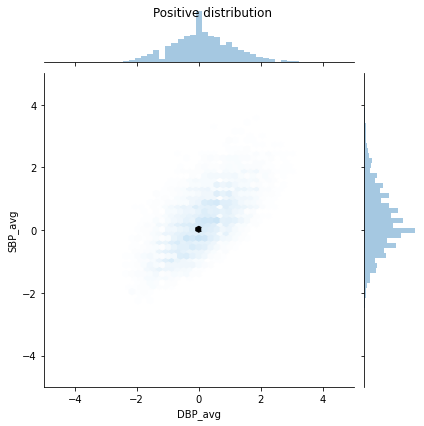

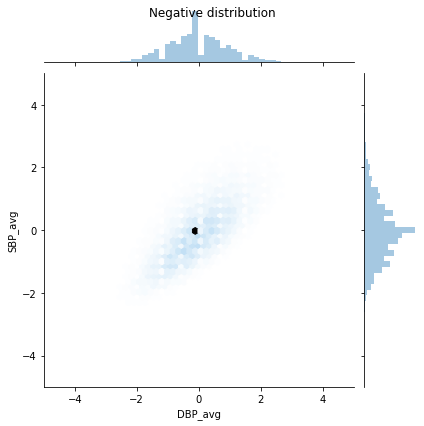

In [38]:
bool_train_labels=df_label["outcomes_1year"]!=0


pos_df = df_input_stnd.loc[df_label["outcomes_1year"]==1]
neg_df = df_input_stnd.loc[df_label["outcomes_1year"]==0]


var1='DBP_avg'
var2='SBP_avg'
sns.jointplot(pos_df[var1], pos_df[var2],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df[var1], neg_df[var2],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

plt.show()

# UMAP

In [358]:
manifold_learner = umap.UMAP()
embedding = manifold_learner.fit_transform(df_input_stnd)

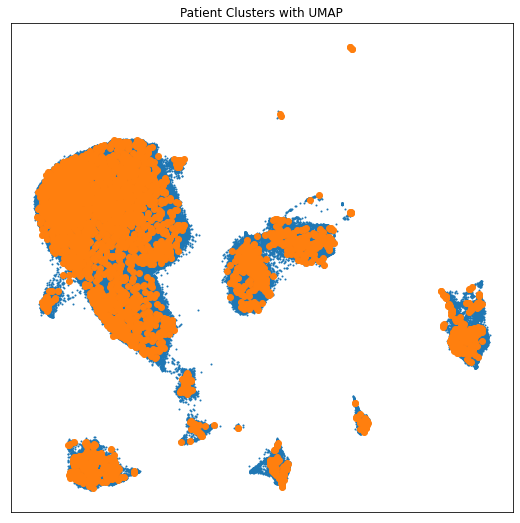

In [359]:
plt.figure(figsize=(9, 9))
plt.xticks([])
plt.yticks([])
plt.title('Patient Clusters with UMAP')
plt.plot(embedding[:, 0], embedding[:, 1], 'o', markersize=1);
plt.plot(embedding[df_label['outcomes_1year'].to_numpy(dtype=bool), 0],
         embedding[df_label['outcomes_1year'].to_numpy(dtype=bool), 1],'o')

# Logistic Regression

In [103]:
#X=df_input_stnd.to_numpy()
#y=df_label['outcomes_1year'].to_numpy()

X=df_input_stnd.loc[indx_age].to_numpy()
y=df_label.loc[indx_age]['outcomes_1year'].to_numpy()

In [40]:
train_d, test_d, train_label_d, test_label_d = train_test_split(X,y, test_size=0.3)
train_d, val_d, train_label_d, val_label_d = train_test_split(train_d,train_label_d, test_size=0.2)

In [41]:
"""lr_pipe = Pipeline(steps=[
('scaler', StandardScaler(with_mean=True, with_std=True)),
('lr', LogisticRegression(solver='liblinear', max_iter=5000, random_state=0))
])
"""
lr_pipe = Pipeline(steps=[
('lr', LogisticRegression(solver='liblinear', class_weight='balanced',max_iter=5000, random_state=0))
])

originalclass = []
predictedclass = []

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

#scores=cross_val_score(lr_pipe, train_d, train_label_d, cv=5,
#                       scoring=make_scorer(classification_report_with_accuracy_score))
#print(scores)
#print(classification_report(originalclass, predictedclass))

In [42]:
#scores=cross_validate(lr_pipe, train_d, train_label_d, cv=5,
#                       scoring=make_scorer(classification_report_with_accuracy_score),return_estimator=True)

In [43]:
# Run classifier with cross-validation and plot ROC curves
def plot_aucpr_aucroc_cv(classifier,X,y,cv,callback_list=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    #calibration curve
    num_cal_bins=1000
    prob_true=np.zeros([cv.n_splits,num_cal_bins]) 
    prob_pred=np.zeros([cv.n_splits,num_cal_bins]) 
    
    feature_importance=[]


    fig, ax = plt.subplots(1,3,figsize=[15,5])
    
    
    
    pbar = tqdm(total=5)
    
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[0])

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(viz.fpr,viz.tpr))

        viz2 = plot_precision_recall_curve(classifier, X[test], y[test],
                             name='PRC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[1])
        recall_temp_sorted_ind=np.argsort(viz2.recall)
        recall_temp_sorted=viz2.recall[recall_temp_sorted_ind]
        precision_temp_sorted=viz2.precision[recall_temp_sorted_ind]
        interp_precision = np.interp(mean_recall,recall_temp_sorted,precision_temp_sorted)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(viz2.recall,viz2.precision)
        avg_precisions.append(viz2.average_precision)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
        print('you got it right')
        
        #calibration curve
        
        prob_true[i,:], prob_pred[i,:]=calibration_curve(y[test],classifier.predict_proba(X[test])[:,1],n_bins=num_cal_bins,strategy='quantile')
        
            
        
        if isinstance(classifier, XGBClassifier):
            feature_importance.append(classifier.feature_importances_)
            

    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='diag', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(avg_precisions)#np.std(aucs_pr)
    ax[1].plot( mean_recall,mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")
    
    
    #Calibration curve
    ax[2].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='perfect calibration', alpha=.8)
    mean_prob_true = np.mean(prob_true, axis=0)
    mean_prob_pred = np.mean(prob_pred, axis=0)
    print(prob_true),print(prob_pred)
    
    std_prob_true=np.std(prob_true, axis=0)

    ax[2].plot(mean_prob_pred, mean_prob_true, color='b',
            label='Mean predicted probability',
            lw=2, alpha=.8)

    prob_true_upper = np.minimum(mean_prob_true + std_prob_true, 1)
    prob_true_lower = np.maximum(mean_prob_true - std_prob_true, 0)
    ax[2].fill_between(mean_prob_pred, prob_true_lower, prob_true_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Calibration Curve")
    ax[2].legend(loc="lower right")


    plt.show()
    
    return feature_importance

In [44]:
"""
tic = time.perf_counter()


#classifier = svm.SVC(kernel='linear', probability=True,random_state=0)
classifier1= LogisticRegression(solver='liblinear',penalty='l1',C=0.01, max_iter=1000,tol=0.01, random_state=0,class_weight='balanced')
#classifier= CalibratedClassifierCV(base_estimator=classifier1, cv=3)
cv = StratifiedKFold(n_splits=5)
plot_aucpr_aucroc_cv(classifier1,train_d,train_label_d,cv)
toc = time.perf_counter()

print('Time elapsed: '+str(toc-tic))
"""

"\ntic = time.perf_counter()\n\n\n#classifier = svm.SVC(kernel='linear', probability=True,random_state=0)\nclassifier1= LogisticRegression(solver='liblinear',penalty='l1',C=0.01, max_iter=1000,tol=0.01, random_state=0,class_weight='balanced')\n#classifier= CalibratedClassifierCV(base_estimator=classifier1, cv=3)\ncv = StratifiedKFold(n_splits=5)\nplot_aucpr_aucroc_cv(classifier1,train_d,train_label_d,cv)\ntoc = time.perf_counter()\n\nprint('Time elapsed: '+str(toc-tic))\n"

In [40]:
# Run classifier with cross-validation and plot ROC curves
def plot_aucpr_aucroc_bs_test_hp(classifierC,X_test,y_test,cv):
    #plot aupr_auroc with bootstraping of the test set to draw uncertainty
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    #calibration curve
    num_cal_bins=100
    prob_true=np.zeros([cv.n_splits,num_cal_bins]) 
    prob_pred=np.zeros([cv.n_splits,num_cal_bins]) 
    
    feature_importance=[]


    fig, ax = plt.subplots(1,3,figsize=[15,5])
    
    
    
    pbar = tqdm(total=5)
    
    classifier=classifierC
    
    rs=cv
    #This randmely samples the test set and and draws graphs/metric for each set
    for i,(sample,_) in enumerate(rs.split(X_test)):        
        viz = plot_roc_curve(classifier.best_estimator_, X_test[sample], y_test[sample],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[0])

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(viz.fpr,viz.tpr))

        viz2 = plot_precision_recall_curve(classifier.best_estimator_,  X_test[sample], y_test[sample],
                             name='PRC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[1])
        recall_temp_sorted_ind=np.argsort(viz2.recall)
        recall_temp_sorted=viz2.recall[recall_temp_sorted_ind]
        precision_temp_sorted=viz2.precision[recall_temp_sorted_ind]
        interp_precision = np.interp(mean_recall,recall_temp_sorted,precision_temp_sorted)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(viz2.recall,viz2.precision)
        avg_precisions.append(viz2.average_precision)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
        print('you got it right')
        
        #calibration curve
        
        prob_true[i,:], prob_pred[i,:]=calibration_curve(y_test[sample],classifier.best_estimator_.predict_proba(X_test[sample])[:,1],n_bins=num_cal_bins,strategy='quantile')
        
            
        
        if isinstance(classifier, XGBClassifier):
            feature_importance.append(classifier.feature_importances_)
            

    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='diag', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(avg_precisions)#np.std(aucs_pr)
    ax[1].plot( mean_recall,mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")
    
    
    #Calibration curve
    ax[2].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='perfect calibration', alpha=.8)
    mean_prob_true = np.mean(prob_true, axis=0)
    mean_prob_pred = np.mean(prob_pred, axis=0)
    print(prob_true),print(prob_pred)
    
    std_prob_true=np.std(prob_true, axis=0)

    ax[2].plot(mean_prob_pred, mean_prob_true, color='b',
            label='Mean predicted probability',
            lw=2, alpha=.8)

    prob_true_upper = np.minimum(mean_prob_true + std_prob_true, 1)
    prob_true_lower = np.maximum(mean_prob_true - std_prob_true, 0)
    ax[2].fill_between(mean_prob_pred, prob_true_lower, prob_true_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Calibration Curve")
    ax[2].legend(loc="lower right")


    plt.show()
    
    return {"classifier":classifier,"feature_importance":feature_importance}






  0%|          | 0/5 [00:00<?, ?it/s]




 20%|██        | 1/5 [00:01<00:05,  1.48s/it]




Fold #0::  20%|██        | 1/5 [00:01<00:05,  1.48s/it]

you got it right







Fold #0::  40%|████      | 2/5 [00:03<00:05,  1.71s/it]




Fold #1::  40%|████      | 2/5 [00:03<00:05,  1.71s/it]

you got it right







Fold #1::  60%|██████    | 3/5 [00:05<00:03,  1.82s/it]




Fold #2::  60%|██████    | 3/5 [00:05<00:03,  1.82s/it]

you got it right







Fold #2::  80%|████████  | 4/5 [00:08<00:01,  1.94s/it]




Fold #3::  80%|████████  | 4/5 [00:08<00:01,  1.94s/it]

you got it right







Fold #3:: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]




Fold #4:: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]

you got it right
[[0.07894737 0.02631579 0.05263158 0.07236842 0.02649007 0.08552632
  0.07894737 0.03289474 0.05921053 0.09933775 0.05921053 0.10526316
  0.05921053 0.06578947 0.07284768 0.05921053 0.09210526 0.09868421
  0.06578947 0.12582781 0.10526316 0.07894737 0.05921053 0.08609272
  0.07236842 0.09868421 0.11184211 0.08552632 0.10596026 0.13815789
  0.11184211 0.11184211 0.11184211 0.14569536 0.10526316 0.09210526
  0.09210526 0.09210526 0.1192053  0.15131579 0.11842105 0.125
  0.1192053  0.13815789 0.15789474 0.09868421 0.15789474 0.13907285
  0.16447368 0.11842105 0.15131579 0.15789474 0.0794702  0.11842105
  0.17763158 0.125      0.15789474 0.1589404  0.14473684 0.13157895
  0.18421053 0.1986755  0.15131579 0.17763158 0.18421053 0.25657895
  0.13907285 0.23684211 0.23026316 0.15131579 0.16447368 0.16556291
  0.17105263 0.17763158 0.13815789 0.16447368 0.16556291 0.19078947
  0.21052632 0.19736842 0.20529801 0.20394737 0.20394737 0.20394737
  0.25657895 0.20529801 0.21052632 0

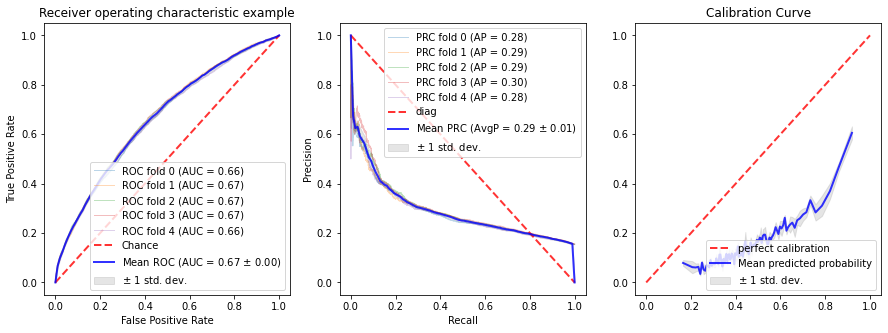

Time elapsed: 288.9337227027863


In [104]:
train_d, test_d, train_label_d, test_label_d = train_test_split(X,y, test_size=0.3)
#train_d, val_d, train_label_d, val_label_d = train_test_split(train_d,train_label_d, test_size=0.2)

tic = time.perf_counter()

#classifier = svm.SVC(kernel='linear', probability=True,random_state=0)
classifierC= LogisticRegression(solver='liblinear',penalty='l1', max_iter=100,tol=0.001, random_state=0,class_weight='balanced')#solver='liblinear',penalty='l1',C=0.01, max_iter=1000,tol=0.01, random_state=0,class_weight='balanced'
fit_params={"sample_weight":None}
hp_params=dict(C=scipy.stats.uniform(loc=0,scale=1))

classifier=RandomizedSearchCV(
    classifierC,
    hp_params,
    n_iter=3,
    scoring='average_precision',
    random_state=0,
    cv=5,
    verbose=0,
)


#classifier= CalibratedClassifierCV(base_estimator=classifier1, cv=3)
classifierF=classifier.fit(train_d,train_label_d,**fit_params)

rs = ShuffleSplit(n_splits=5,test_size=.5)

#fit params is for Early stopping
results_dict=plot_aucpr_aucroc_bs_test_hp(classifierF,test_d,test_label_d,rs)
toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))

In [ ]:
"""
tic = time.perf_counter()
neg_class, pos_class = np.bincount(y.astype(int))
classifier= XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=1000,scale_pos_weight=neg_class/pos_class)
cv = StratifiedKFold(n_splits=5)
feature_importance=plot_aucpr_aucroc_cv(classifier,X,y,cv)
toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))
"""

In [ ]:
"""
fig,ax=plt.subplots(figsize=(30,15))
mean_feature_importance=np.mean(feature_importance,axis=0)
std_feature_importance=np.std(feature_importance,axis=0)
sorted_idx=np.argsort(mean_feature_importance)

plt.barh(df_input.columns.values[sorted_idx][-50:]
         mean_feature_importance[sorted_idx][-50:],
         xerr=std_feature_importance[sorted_idx][-50:])
fig.savefig('features')
"""

In [ ]:
#df_input.columns.values[sorted_idx][-20:]

In [48]:
train_d, test_d, train_label_d, test_label_d = train_test_split(X,y, test_size=0.3)
train_d, val_d, train_label_d, val_label_d = train_test_split(train_d,train_label_d, test_size=0.2)

[0]	validation_0-aucpr:0.10361
[1]	validation_0-aucpr:0.11067
[2]	validation_0-aucpr:0.12466
[3]	validation_0-aucpr:0.12895
[4]	validation_0-aucpr:0.12839
[5]	validation_0-aucpr:0.12466
[6]	validation_0-aucpr:0.12069
[7]	validation_0-aucpr:0.12034
[8]	validation_0-aucpr:0.11931
[9]	validation_0-aucpr:0.12250
[10]	validation_0-aucpr:0.12487
[11]	validation_0-aucpr:0.12379
[12]	validation_0-aucpr:0.12506
[13]	validation_0-aucpr:0.12647
[14]	validation_0-aucpr:0.12838
[15]	validation_0-aucpr:0.12880
[16]	validation_0-aucpr:0.12799
[17]	validation_0-aucpr:0.12686
[18]	validation_0-aucpr:0.12590
[19]	validation_0-aucpr:0.12495
[20]	validation_0-aucpr:0.12680
[21]	validation_0-aucpr:0.12821
[22]	validation_0-aucpr:0.12927
[23]	validation_0-aucpr:0.12873
[24]	validation_0-aucpr:0.12849
[25]	validation_0-aucpr:0.12967
[26]	validation_0-aucpr:0.13059
[27]	validation_0-aucpr:0.13143
[28]	validation_0-aucpr:0.13212
[29]	validation_0-aucpr:0.13301
[30]	validation_0-aucpr:0.13223
[31]	validation_0-





  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:24<01:37, 24.48s/it]



Fold #0::  20%|██        | 1/5 [00:24<01:37, 24.48s/it]

you got it right






Fold #0::  40%|████      | 2/5 [01:04<01:27, 29.22s/it]



Fold #1::  40%|████      | 2/5 [01:04<01:27, 29.22s/it]

you got it right






Fold #1::  60%|██████    | 3/5 [01:30<00:56, 28.12s/it]



Fold #2::  60%|██████    | 3/5 [01:30<00:56, 28.12s/it]

you got it right






Fold #2::  80%|████████  | 4/5 [01:54<00:27, 27.06s/it]



Fold #3::  80%|████████  | 4/5 [01:54<00:27, 27.06s/it]

you got it right






Fold #3:: 100%|██████████| 5/5 [02:32<00:00, 30.24s/it]



Fold #4:: 100%|██████████| 5/5 [02:32<00:00, 30.24s/it]

you got it right
[[0.00432277 0.00288184 0.004329   0.00864553 0.00432277 0.004329
  0.00576369 0.00720461 0.00577201 0.00720461 0.00576369 0.00721501
  0.01152738 0.01008646 0.00577201 0.00864553 0.01008646 0.00721501
  0.01729107 0.00576369 0.01010101 0.01152738 0.01440922 0.01010101
  0.01585014 0.02161383 0.01731602 0.01729107 0.01729107 0.02597403
  0.01152738 0.0129683  0.02308802 0.02449568 0.03025937 0.01298701
  0.02449568 0.03025937 0.04184704 0.02881844 0.01729107 0.02453102
  0.02449568 0.02737752 0.03463203 0.03170029 0.03170029 0.02886003
  0.02161383 0.03607504 0.03746398 0.04178674 0.03896104 0.04034582
  0.03314121 0.04329004 0.03746398 0.04178674 0.03896104 0.03458213
  0.05475504 0.04617605 0.03170029 0.04899135 0.04184704 0.04178674
  0.06340058 0.04617605 0.04899135 0.06195965 0.06204906 0.05619597
  0.05907781 0.06493506 0.06340058 0.05763689 0.06493506 0.05475504
  0.06916427 0.07070707 0.08357349 0.0778098  0.0981241  0.06916427
  0.08069164 0.07503608 0.1066282

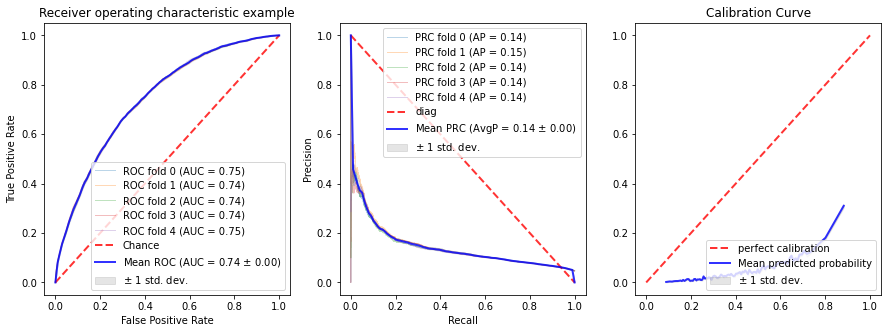

Time elapsed: 11118.743127273396


In [62]:
tic = time.perf_counter()
neg_class, pos_class = np.bincount(y.astype(int))

classifierC= XGBClassifier(scale_pos_weight=neg_class/pos_class,eval_metric='logloss',use_label_encoder =False)

fit_params={"early_stopping_rounds":20,
                "eval_metric" : "aucpr", 
                "eval_set" : [[val_d, val_label_d]]
               }


hp_params=dict(
              min_child_weight=[5,10,20,50],
              gamma=[0.5,1,1.5,2,5,10],
              max_depth=[5,6,7,8,9,10],
              subsample= [0.6, 0.8, 1.0],
               colsample_bytree=[0.6, 0.8, 1.0],
               learning_rate=[0.005,0.01,0.02,0.05,0.1],
               n_estimators=[200,400,600,800,1000]
              )
rs = ShuffleSplit(n_splits=5,test_size=.5)

#for this I'm replacing fit with BayeSearchCV for nested CV hyperparameter tuning     RandomizedSearchCV
#n_iter=100,cv=5
classifier=RandomizedSearchCV(
    classifierC,
    hp_params,
    n_iter=10,
    scoring='average_precision',
    random_state=0,
    cv=5,
    verbose=0,
)

classifier=classifier.fit(train_d,train_label_d,**fit_params)

#fit params is for Early stopping
results_dict=plot_aucpr_aucroc_bs_test_hp(classifier,test_d,test_label_d,rs)
toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))

# DNN

In [53]:
plt.show()

In [52]:
#train_df, test_df, train_label_df, test_label_df = train_test_split(df_input_stnd,df_label["MI_60"], test_size=0.2)

In [39]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Positives: ', np.sum(cm[1]))


2021-11-04 17:41:54.478382: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-04 17:41:54.479982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-04 17:41:54.492944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2021-11-04 17:41:54.494149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:81:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2021-11-04 17:41:54.494197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-04 17:41:54.496099:

logs/csvLogs


2021-11-04 17:44:28.085288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-04 17:44:28.085955: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2294695000 Hz
2021-11-04 17:44:30.057548: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-04 17:44:30.501692: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 17:44:30.501732: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 17:44:30.503030: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2021-11-04 17:44:30.517146: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


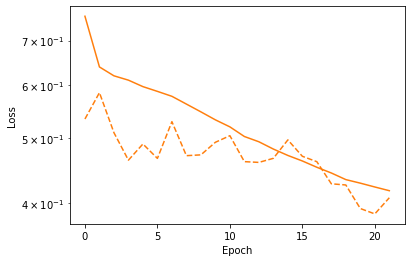

In [40]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, input_shape=None, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.Input(shape=(input_shape,)),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(60, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

def make_dir_for_callback_obj(callback_list):
    for callbackobj in callback_list:
        if  isinstance(callbackobj,tf.keras.callbacks.CSVLogger):
            dir_path=''
            for sub_dir in callbackobj.filename.split('/')[:-1]:
                dir_path=os.path.join(dir_path,sub_dir)
            print(dir_path)
                

            csv_file_name=callbackobj.filename.split('/')[-1]
            try:
                os.makedirs(dir_path)
            except FileExistsError:
                pass
                
    return


# split and shuffle 
X=df_input_stnd.to_numpy()
y=df_label['outcomes_1year'].to_numpy()
train_d, test_d, train_label_d, test_label_d = train_test_split(X,y, test_size=0.3)
train_d, val_d, train_label_d, val_label_d = train_test_split(train_d,train_label_d, test_size=0.2)

train=np.array(train_d).astype('float32')
val=np.array(val_d).astype('float32')
train_label=np.array(train_label_d).astype('float32')
val_label=np.array(val_label_d).astype('float32')
test=np.array(test_d).astype('float32')
test_label=np.array(test_label_d).astype('float32')





EPOCHS = 100
BATCH_SIZE = 2000


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



neg, pos = np.bincount(df_label['outcomes_1year'])
weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}


model = make_model(output_bias=np.log([pos/neg]),input_shape=train.shape[-1])


MODEL_NAME='FFDNN'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]

make_dir_for_callback_obj(callback_list)

model=model.fit(
    train,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callback_list,
    validation_data=(val, val_label),
    verbose=0,
    class_weight=class_weight)
plot_loss(model, "Careful Bias", 1)

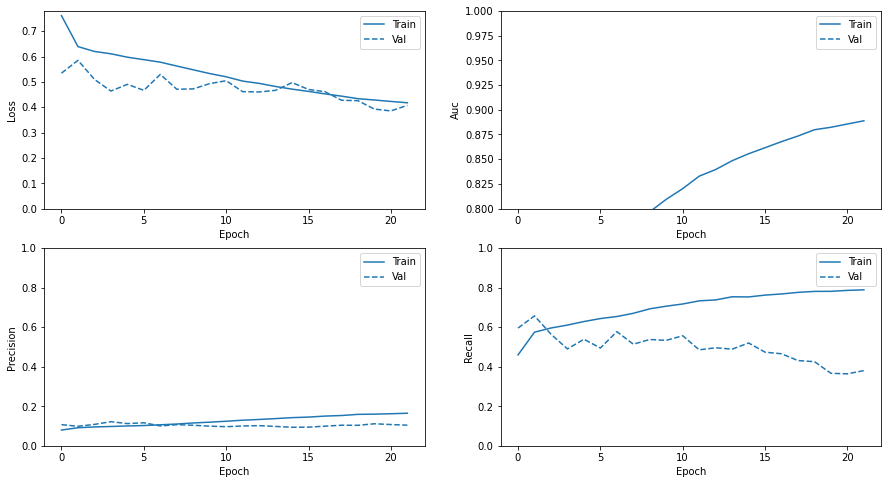

In [41]:
plt.subplots(figsize=(15,8))
plot_metrics(model)

70/70 [==============================] - 1s 9ms/step - loss: 0.5851 - tp: 4253.0000 - fp: 39703.0000 - tn: 92536.0000 - fn: 2243.0000 - accuracy: 0.6977 - precision: 0.0968 - recall: 0.6547 - auc: 0.7462
loss :  0.5850967168807983
tp :  4253.0
fp :  39703.0
tn :  92536.0
fn :  2243.0
accuracy :  0.6976538300514221
precision :  0.09675584733486176
recall :  0.654710590839386
auc :  0.7462313771247864

True Negatives:  92536
False Positives:  39703
False Negatives:  2243
True Positives:  4253
Total Positives:  6496


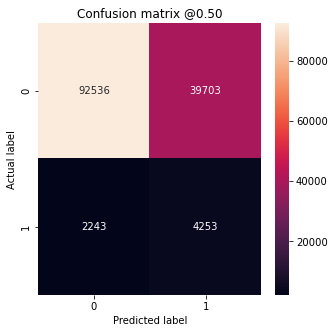

In [42]:

results = model.model.evaluate(test,test_label, batch_size=BATCH_SIZE )
for name, value in zip(model.model.metrics_names,results):
  print(name, ': ', value)
print()

plot_cm(test_label, model.model.predict(test,batch_size=BATCH_SIZE),0.5)


In [43]:
model.history

{'loss': [0.7611239552497864,
  0.6391961574554443,
  0.6199634671211243,
  0.6107659339904785,
  0.5973182320594788,
  0.5876211524009705,
  0.5777255296707153,
  0.5624784231185913,
  0.5475934743881226,
  0.5327535271644592,
  0.5200190544128418,
  0.5030595064163208,
  0.4940292239189148,
  0.48176857829093933,
  0.4712938964366913,
  0.4624156951904297,
  0.45249468088150024,
  0.44365787506103516,
  0.433673232793808,
  0.42841067910194397,
  0.4227951467037201,
  0.417416512966156],
 'tp': [5515.0,
  6893.0,
  7146.0,
  7323.0,
  7538.0,
  7718.0,
  7842.0,
  8038.0,
  8309.0,
  8469.0,
  8603.0,
  8792.0,
  8849.0,
  9040.0,
  9031.0,
  9141.0,
  9212.0,
  9307.0,
  9367.0,
  9370.0,
  9428.0,
  9461.0],
 'fp': [63640.0,
  68459.0,
  67747.0,
  67578.0,
  67580.0,
  67542.0,
  65947.0,
  64963.0,
  63587.0,
  62349.0,
  60653.0,
  59099.0,
  57549.0,
  56619.0,
  54356.0,
  53767.0,
  52078.0,
  51448.0,
  49522.0,
  49192.0,
  48668.0,
  47989.0],
 'tn': [183340.0,
  178521.0,

In [44]:
# Run classifier with cross-validation and plot ROC curves
from sklearn.metrics import PrecisionRecallDisplay

def plot_aucpr_aucroc_test_nn(model,X_test,y_test,cv,fit_params=None,callback_list=None):
    #plot aupr_auroc with bootstraping of the test set to draw uncertainty
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    #calibration curve
    num_cal_bins=100
    prob_true=np.zeros([cv.n_splits,num_cal_bins]) 
    prob_pred=np.zeros([cv.n_splits,num_cal_bins]) 
    
    feature_importance=[]


    fig, ax = plt.subplots(1,3,figsize=[15,5])
    
    
    
    pbar = tqdm(total=5)
    
    

    #for this I'm replacing fit with BayeSearchCV for nested CV hyperparameter tuning     RandomizedSearchCV
    """classifier=RandomizedSearchCV(
        classifierC,
        hp_params_dict,
        n_iter=100,
        scoring='average_precision',
        random_state=0,
        cv=5,
        verbose=10
    )
    """
       
    #fit params is for Early stopping
    #classifier=classifier.fit(X_train,y_train)
    
    
    
    
    rs=cv
    #This randmely samples the test set and and draws graphs/metric for each set
    for i,(sample,_) in enumerate(rs.split(X_test)):
        y_pred_keras = model.predict(X_test[sample]).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test[sample], y_pred_keras)

        interp_tpr = np.interp(mean_fpr, fpr_keras, tpr_keras)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_keras, tpr_keras))

        precision_keras, recall_keras, thresholds_keras = precision_recall_curve(y_test[sample], y_pred_keras)
        recall_temp_sorted_ind=np.argsort(recall_keras)
        recall_temp_sorted=recall_keras[recall_temp_sorted_ind]
        precision_temp_sorted=precision_keras[recall_temp_sorted_ind]
        interp_precision = np.interp(mean_recall,recall_temp_sorted,precision_temp_sorted)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(recall_keras,precision_keras)
        avg_precisions.append(aucs_pr)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
        print('you got it right')
        
        #calibration curve
        
        prob_true[i,:], prob_pred[i,:]=calibration_curve(y_test[sample],model.predict(X_test[sample]),n_bins=num_cal_bins,strategy='quantile')
            

    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='diag', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(avg_precisions)#np.std(aucs_pr)
    
    ax[1].plot( mean_recall,mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")
    
    
    #Calibration curve
    ax[2].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='perfect calibration', alpha=.8)
    mean_prob_true = np.mean(prob_true, axis=0)
    mean_prob_pred = np.mean(prob_pred, axis=0)
    print(prob_true),print(prob_pred)
    
    std_prob_true=np.std(prob_true, axis=0)

    ax[2].plot(mean_prob_pred, mean_prob_true, color='b',
            label='Mean predicted probability',
            lw=2, alpha=.8)

    prob_true_upper = np.minimum(mean_prob_true + std_prob_true, 1)
    prob_true_lower = np.maximum(mean_prob_true - std_prob_true, 0)
    ax[2].fill_between(mean_prob_pred, prob_true_lower, prob_true_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Calibration Curve")
    ax[2].legend(loc="lower right")

    fig.save()
    fig.show()
    
    return {"classifier":model}

In [45]:
def make_model_hp(hp, metrics=METRICS, input_shape=None, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential()
    model.add(keras.Input(shape=(train.shape[1],)))    #'num_layers',  'units_', 'dropout_','learning_rate'
    for i in range(hp.Int('num_layers',2,5)):
        model.add(keras.layers.Dense(hp.Int('units_'+str(i), 
                                        min_value = 32, 
                                        max_value = 256, 
                                        step = 32,
                                        default=32),
                                 activation='relu'))
        model.add(keras.layers.Dropout(hp.Float('dropout_'+str(i),
                    min_value=0.0,
                    max_value=0.4,
                    default=0.01,
                    step=0.01)))
    

    model.add(keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model




class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [46]:
MODEL_NAME='hyper_DNN_MNS_SocioEcon'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]

tic = time.perf_counter()

make_dir_for_callback_obj(callback_list)

tuner=kt.tuners.bayesian.BayesianOptimization(make_model_hp,
                     objective = kt.Objective("val_auc", direction="max"), 
                     max_trials=10,
                     seed = 42,
                     executions_per_trial=3,
                     directory = 'logs/kt/21_11_4_DNN_minusScioEcon')

tuner.search(train, train_label, epochs = 50, 
             validation_data = (val, val_label), 
             callbacks = callback_list,
            verbose=0)

toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))

logs/csvLogs


2021-11-04 17:45:22.330869: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 17:45:22.330916: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 17:45:22.331076: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-04 17:45:22.331118: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 17:45:26.121942: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 17:45:26.121985: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 17:45:26.122097: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2021-11-04 17:45:26.338152: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 17:45:26.341928: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 17:45:26.345979: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 17:45:26.349224: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/d6faebe8fc9d69ea57a947dcd9444b13/execution0/train/plugins/profile/2021_11_04_17_45_26
2021-11-04 17:45:26.351023: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/d6faebe8fc9d69ea57a947dcd9444b13/execution0/train/plugins/profile/2021_11_04_17_45_26/deepmedicine.trace.json.gz
2021-11-04 17:45:26.364881: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


2021-11-04 18:09:31.897701: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 18:09:31.897738: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 18:09:31.897950: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 18:09:32.087939: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 18:09:32.091277: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 18:09:32.095274: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 18:09:32.098135: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/d6faebe8fc9d69ea57a947dcd9444b13/execution1/train/plugins/profile/2021_11_04_18_09_32
2021-11-04 18:09:32.099895: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/d6faebe8fc9d69ea57a947dcd9444b13/execution1/train/plugins/profile/2021_11_04_18_09_32/deepmedicine.trace.json.gz
2021-11-04 18:09:32.111415: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


2021-11-04 18:34:23.310833: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 18:34:23.310877: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 18:34:23.311083: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 18:34:23.550461: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 18:34:23.554261: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 18:34:23.558884: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 18:34:23.562199: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/d6faebe8fc9d69ea57a947dcd9444b13/execution2/train/plugins/profile/2021_11_04_18_34_23
2021-11-04 18:34:23.564332: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/d6faebe8fc9d69ea57a947dcd9444b13/execution2/train/plugins/profile/2021_11_04_18_34_23/deepmedicine.trace.json.gz
2021-11-04 18:34:23.577440: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


2021-11-04 18:58:36.091445: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 18:58:36.091498: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 18:58:36.091770: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 18:58:36.270338: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 18:58:36.273529: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 18:58:36.277602: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 18:58:36.280536: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/a946afb227ed828d9f1f148ef3a663a4/execution0/train/plugins/profile/2021_11_04_18_58_36
2021-11-04 18:58:36.282296: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/a946afb227ed828d9f1f148ef3a663a4/execution0/train/plugins/profile/2021_11_04_18_58_36/deepmedicine.trace.json.gz
2021-11-04 18:58:36.293663: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-04 19:24:29.084640: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 19:24:29.084680: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 19:24:29.084858: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 19:24:29.369052: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 19:24:29.374342: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 19:24:29.380264: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 19:24:29.384715: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/a946afb227ed828d9f1f148ef3a663a4/execution1/train/plugins/profile/2021_11_04_19_24_29
2021-11-04 19:24:29.387635: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/a946afb227ed828d9f1f148ef3a663a4/execution1/train/plugins/profile/2021_11_04_19_24_29/deepmedicine.trace.json.gz
2021-11-04 19:24:29.403956: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-04 19:50:11.662689: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 19:50:11.662728: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 19:50:11.662930: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 19:50:11.842087: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 19:50:11.845318: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 19:50:11.849325: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 19:50:11.852173: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/a946afb227ed828d9f1f148ef3a663a4/execution2/train/plugins/profile/2021_11_04_19_50_11
2021-11-04 19:50:11.853996: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/a946afb227ed828d9f1f148ef3a663a4/execution2/train/plugins/profile/2021_11_04_19_50_11/deepmedicine.trace.json.gz
2021-11-04 19:50:11.865108: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-04 20:15:51.994414: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x559345199bf0
2021-11-04 20:15:51.995271: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2021-11-04 20:15:52.569973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-04 20:16:00.075915: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 20:16:00.075957: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 20:16:00.076140: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 20:16:00.256063: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 20:16:00.259319: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 20:16:00.263348: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 20:16:00.266320: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/df9879cad76eed2756e8c4a2a9e1abf3/execution0/train/plugins/profile/2021_11_04_20_16_00
2021-11-04 20:16:00.268135: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/df9879cad76eed2756e8c4a2a9e1abf3/execution0/train/plugins/profile/2021_11_04_20_16_00/deepmedicine.trace.json.gz
2021-11-04 20:16:00.279472: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-04 20:41:54.596153: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 20:41:54.596206: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 20:41:54.596415: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 20:41:54.871400: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 20:41:54.875478: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 20:41:54.880317: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 20:41:54.883853: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/df9879cad76eed2756e8c4a2a9e1abf3/execution1/train/plugins/profile/2021_11_04_20_41_54
2021-11-04 20:41:54.886163: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/df9879cad76eed2756e8c4a2a9e1abf3/execution1/train/plugins/profile/2021_11_04_20_41_54/deepmedicine.trace.json.gz
2021-11-04 20:41:54.900111: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-04 21:08:48.923378: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 21:08:48.923425: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 21:08:48.923665: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-04 21:08:49.098719: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.


2021-11-04 21:08:49.102036: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 21:08:49.106081: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 21:08:49.108982: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/df9879cad76eed2756e8c4a2a9e1abf3/execution2/train/plugins/profile/2021_11_04_21_08_49
2021-11-04 21:08:49.110757: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/df9879cad76eed2756e8c4a2a9e1abf3/execution2/train/plugins/profile/2021_11_04_21_08_49/deepmedicine.trace.json.gz
2021-11-04 21:08:49.121958: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/df9879cad76

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-04 21:34:53.651792: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 21:34:53.651843: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 21:34:53.652136: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 21:34:53.858659: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 21:34:53.862243: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 21:34:53.866885: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 21:34:53.870289: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/eb516f82194811dca676541de8503130/execution0/train/plugins/profile/2021_11_04_21_34_53
2021-11-04 21:34:53.872392: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/eb516f82194811dca676541de8503130/execution0/train/plugins/profile/2021_11_04_21_34_53/deepmedicine.trace.json.gz
2021-11-04 21:34:53.884758: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-04 21:58:50.884903: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 21:58:50.884938: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 21:58:50.885125: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 21:58:51.072748: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 21:58:51.075742: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 21:58:51.079717: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 21:58:51.083196: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/eb516f82194811dca676541de8503130/execution1/train/plugins/profile/2021_11_04_21_58_51
2021-11-04 21:58:51.084938: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/eb516f82194811dca676541de8503130/execution1/train/plugins/profile/2021_11_04_21_58_51/deepmedicine.trace.json.gz
2021-11-04 21:58:51.094889: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-04 22:23:59.346360: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 22:23:59.346406: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 22:23:59.346727: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 22:23:59.549185: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 22:23:59.552991: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 22:23:59.557771: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 22:23:59.561087: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/eb516f82194811dca676541de8503130/execution2/train/plugins/profile/2021_11_04_22_23_59
2021-11-04 22:23:59.563179: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/eb516f82194811dca676541de8503130/execution2/train/plugins/profile/2021_11_04_22_23_59/deepmedicine.trace.json.gz
2021-11-04 22:23:59.576278: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-04 22:48:03.238909: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 22:48:03.238966: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 22:48:03.239306: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 22:48:03.446958: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 22:48:03.450532: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 22:48:03.455201: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 22:48:03.458636: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/67f574733fab1f77504f494517ec55a3/execution0/train/plugins/profile/2021_11_04_22_48_03
2021-11-04 22:48:03.460818: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/67f574733fab1f77504f494517ec55a3/execution0/train/plugins/profile/2021_11_04_22_48_03/deepmedicine.trace.json.gz
2021-11-04 22:48:03.473130: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


2021-11-04 23:14:34.562489: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 23:14:34.562536: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 23:14:34.562803: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-04 23:14:34.788273: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 23:14:34.791881: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 23:14:34.796493: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 23:14:34.799835: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/67f574733fab1f77504f494517ec55a3/execution1/train/plugins/profile/2021_11_04_23_14_34
2021-11-04 23:14:34.802033: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/67f574733fab1f77504f494517ec55a3/execution1/train/plugins/profile/2021_11_04_23_14_34/deepmedicine.trace.json.gz
2021-11-04 23:14:34.813915: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-04 23:39:19.714525: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-04 23:39:19.714564: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-04 23:39:19.714837: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-04 23:39:19.881258: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-04 23:39:19.884305: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 23:39:19.888303: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-04 23:39:19.891156: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-05 00:04:41.519648: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 00:04:41.519692: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 00:04:41.519920: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-05 00:04:41.687336: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 00:04:41.690348: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 00:04:41.694354: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 00:04:41.697243: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-05 00:29:05.815469: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 00:29:05.815516: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 00:29:05.815832: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 00:29:06.013197: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 00:29:06.016736: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 00:29:06.022929: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 00:29:06.026199: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/20d2bf59ed29750515ce126a8491eb07/execution1/train/plugins/profile/2021_11_05_00_29_06
2021-11-05 00:29:06.028295: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/20d2bf59ed29750515ce126a8491eb07/execution1/train/plugins/profile/2021_11_05_00_29_06/deepmedicine.trace.json.gz
2021-11-05 00:29:06.040092: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


2021-11-05 00:52:33.437805: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 00:52:33.437856: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 00:52:33.438175: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 00:52:33.635693: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 00:52:33.639236: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 00:52:33.643834: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 00:52:33.647198: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/20d2bf59ed29750515ce126a8491eb07/execution2/train/plugins/profile/2021_11_05_00_52_33
2021-11-05 00:52:33.649338: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/20d2bf59ed29750515ce126a8491eb07/execution2/train/plugins/profile/2021_11_05_00_52_33/deepmedicine.trace.json.gz
2021-11-05 00:52:33.661281: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-05 01:16:56.738247: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 01:16:56.738287: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 01:16:56.738526: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-05 01:16:56.905561: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 01:16:56.908593: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 01:16:56.912563: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 01:16:56.915500: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-05 01:40:58.171019: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 01:40:58.171064: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 01:40:58.171320: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-05 01:40:58.338875: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 01:40:58.341864: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 01:40:58.345782: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 01:40:58.348509: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-05 02:05:01.743914: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 02:05:01.743954: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 02:05:01.744226: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 02:05:01.962524: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 02:05:01.966118: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 02:05:01.970781: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 02:05:01.974108: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/ec2cbc1d887c3a45433abbbf4ec326c6/execution2/train/plugins/profile/2021_11_05_02_05_01
2021-11-05 02:05:01.976250: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/ec2cbc1d887c3a45433abbbf4ec326c6/execution2/train/plugins/profile/2021_11_05_02_05_01/deepmedicine.trace.json.gz
2021-11-05 02:05:01.988496: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


2021-11-05 02:28:15.541842: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 02:28:15.541887: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 02:28:15.542174: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 02:28:15.746663: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 02:28:15.750257: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 02:28:15.754782: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 02:28:15.758157: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/53845be5fb10c94d6c4dd7f6c0919dc8/execution0/train/plugins/profile/2021_11_05_02_28_15
2021-11-05 02:28:15.760372: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/53845be5fb10c94d6c4dd7f6c0919dc8/execution0/train/plugins/profile/2021_11_05_02_28_15/deepmedicine.trace.json.gz
2021-11-05 02:28:15.772714: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-05 02:53:29.826388: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 02:53:29.826436: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 02:53:29.826690: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 02:53:30.030541: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 02:53:30.034515: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 02:53:30.039546: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 02:53:30.042850: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/53845be5fb10c94d6c4dd7f6c0919dc8/execution1/train/plugins/profile/2021_11_05_02_53_30
2021-11-05 02:53:30.044976: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/53845be5fb10c94d6c4dd7f6c0919dc8/execution1/train/plugins/profile/2021_11_05_02_53_30/deepmedicine.trace.json.gz
2021-11-05 02:53:30.056855: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


2021-11-05 03:19:28.673674: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 03:19:28.673719: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 03:19:28.673995: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 03:19:28.874791: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 03:19:28.878401: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 03:19:28.882940: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 03:19:28.886276: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/53845be5fb10c94d6c4dd7f6c0919dc8/execution2/train/plugins/profile/2021_11_05_03_19_28
2021-11-05 03:19:28.888407: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/53845be5fb10c94d6c4dd7f6c0919dc8/execution2/train/plugins/profile/2021_11_05_03_19_28/deepmedicine.trace.json.gz
2021-11-05 03:19:28.900321: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-05 03:45:00.537367: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 03:45:00.537408: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 03:45:00.537656: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-05 03:45:00.709899: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 03:45:00.712869: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 03:45:00.716814: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 03:45:00.719714: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-05 04:10:19.876708: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 04:10:19.876754: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 04:10:19.877077: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 04:10:20.107526: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 04:10:20.112721: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 04:10:20.119211: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 04:10:20.123961: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/f333cc950d11fdd64b11db8874c39db4/execution1/train/plugins/profile/2021_11_05_04_10_20
2021-11-05 04:10:20.127043: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/f333cc950d11fdd64b11db8874c39db4/execution1/train/plugins/profile/2021_11_05_04_10_20/deepmedicine.trace.json.gz
2021-11-05 04:10:20.143631: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-05 04:35:33.717951: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 04:35:33.718001: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 04:35:33.718312: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 04:35:33.918543: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 04:35:33.922157: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 04:35:33.926796: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 04:35:33.930185: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/f333cc950d11fdd64b11db8874c39db4/execution2/train/plugins/profile/2021_11_05_04_35_33
2021-11-05 04:35:33.932312: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/f333cc950d11fdd64b11db8874c39db4/execution2/train/plugins/profile/2021_11_05_04_35_33/deepmedicine.trace.json.gz
2021-11-05 04:35:33.944545: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


2021-11-05 05:00:36.071783: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 05:00:36.071824: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 05:00:36.072059: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-05 05:00:36.240784: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 05:00:36.243839: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 05:00:36.247795: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 05:00:36.250664: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-05 05:24:44.518837: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 05:24:44.518891: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 05:24:44.519176: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 05:24:44.726581: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 05:24:44.730177: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 05:24:44.734772: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 05:24:44.738109: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/62632835e4da926871e5b4007ba5bb58/execution1/train/plugins/profile/2021_11_05_05_24_44
2021-11-05 05:24:44.740249: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/62632835e4da926871e5b4007ba5bb58/execution1/train/plugins/profile/2021_11_05_05_24_44/deepmedicine.trace.json.gz
2021-11-05 05:24:44.752229: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


2021-11-05 05:48:33.843583: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 05:48:33.843623: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 05:48:33.843857: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


2021-11-05 05:48:34.035936: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-11-05 05:48:34.039043: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-05 05:48:34.043105: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 05:48:34.046048: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/62632835e4da926871e5b4007ba5bb58/execution2/train/plugins/profile/2021_11_05_05_48_34
2021-11-05 05:48:34.047857: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/TensorBoard/hyper_DNN_MNS_SocioEcon_21_11_04_17_45/62632835e4da926871e5b4007ba5bb58/execution2/train/plugins/profile/2021_11_05_05_48_34/deepmedicine.trace.json.gz
2021-11-05 05:48:34.058400: I tensorflow/core/profiler/rp

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
INFO:tensorflow:Oracle triggered exit
Time elapsed: 44949.73083458748


In [47]:
tuner.results_summary()

Results summary
Results in logs/kt/21_11_4_DNN_minusScioEcon/untitled_project
Showing 10 best trials
Objective(name='val_auc', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout_0: 0.0
units_1: 32
dropout_1: 0.01
learning_rate: 0.0001
units_2: 256
dropout_2: 0.0
units_3: 256
dropout_3: 0.0
Score: 0.741387665271759
Trial summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout_0: 0.0
units_1: 32
dropout_1: 0.0
learning_rate: 0.0001
units_2: 32
dropout_2: 0.0
units_3: 256
dropout_3: 0.04
Score: 0.7411463061968485
Trial summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout_0: 0.0
units_1: 32
dropout_1: 0.4
learning_rate: 0.0001
units_2: 256
dropout_2: 0.0
units_3: 256
dropout_3: 0.0
Score: 0.7411185304323832
Trial summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout_0: 0.0
units_1: 32
dropout_1: 0.0
learning_rate: 0.0001
units_2: 256
dropout_2: 0.0
units_3: 160
dropout_3: 0.32
Score: 0.7403211792310079
Trial summary
Hyperparameters:
num_layers: 

In [48]:
tuner.get_best_models(num_models=1)[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                33760     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 34,849
Trainable params: 34,849
Non-trainable params: 0
_________________________________________________________________


In [49]:
tuner.get_best_hyperparameters()[0].get('learning_rate')

0.0001

logs/csvLogs


2021-11-05 06:14:33.206356: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 06:14:33.206397: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 06:14:33.206654: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-05 06:14:33.206679: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 06:14:35.842745: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 06:14:35.842793: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 06:14:35.842910: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping


Fold #0::  20%|██████████████████▊                                                                           | 1/5 [00:03<00:13,  3.25s/it]

you got it right


Fold #1::  40%|█████████████████████████████████████▌                                                        | 2/5 [00:09<00:14,  4.84s/it]

you got it right


Fold #2::  60%|████████████████████████████████████████████████████████▍                                     | 3/5 [00:14<00:09,  4.99s/it]

you got it right


Fold #3::  80%|███████████████████████████████████████████████████████████████████████████▏                  | 4/5 [00:19<00:05,  5.22s/it]

you got it right


Fold #4:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.42s/it]

you got it right
[[0.00432277 0.00720461 0.01010101 0.01008646 0.00144092 0.004329
  0.00432277 0.01008646 0.01587302 0.00576369 0.00864553 0.01154401
  0.00576369 0.01008646 0.01298701 0.0129683  0.00864553 0.00865801
  0.01440922 0.01873199 0.01010101 0.00864553 0.0129683  0.01010101
  0.01729107 0.02161383 0.01154401 0.01152738 0.0129683  0.01875902
  0.0129683  0.02737752 0.03030303 0.02881844 0.01440922 0.02164502
  0.02161383 0.02305476 0.02597403 0.02161383 0.02449568 0.02597403
  0.0259366  0.02161383 0.02597403 0.0259366  0.03746398 0.01875902
  0.03170029 0.02453102 0.04034582 0.02881844 0.03607504 0.03602305
  0.02737752 0.03896104 0.03746398 0.04178674 0.04906205 0.04178674
  0.04034582 0.05194805 0.0389049  0.0648415  0.05050505 0.04617605
  0.05035971 0.04761905 0.04178674 0.04322767 0.06204906 0.0648415
  0.04899135 0.05916306 0.05331412 0.05475504 0.06782107 0.06772334
  0.06340058 0.06349206 0.08501441 0.07636888 0.06493506 0.08213256
  0.08501441 0.07792208 0.09654179

AttributeError: 'Figure' object has no attribute 'save'

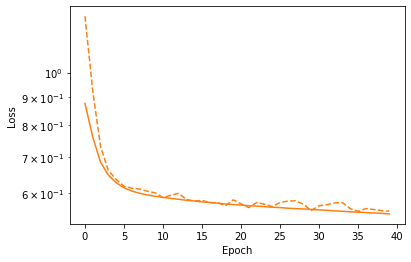

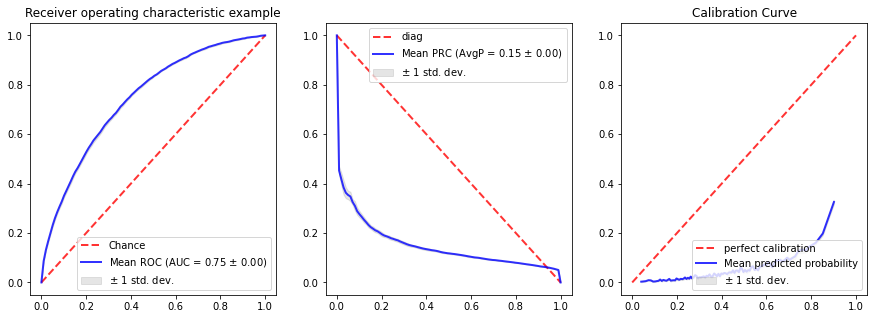

In [50]:
tic = time.perf_counter()

EPOCHS = 100
BATCH_SIZE = 2000


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



neg, pos = np.bincount(df_label['outcomes_1year'])
weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}


model= tf.keras.models.clone_model(tuner.get_best_models(num_models=1)[0])
model.save_weights('model_DNN_initial_weights.h5')
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)


MODEL_NAME='FFDNNwithHPmnsSocioEcon'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]

make_dir_for_callback_obj(callback_list)

history=model.fit(
    train,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callback_list,
    validation_data=(val, val_label),
    verbose=0,
    class_weight=class_weight)
plot_loss(history, "Careful Bias", 1)



cv=ShuffleSplit(n_splits=5,test_size=.5)

plot_aucpr_aucroc_test_nn(model,test,test_label,cv,fit_params=None,callback_list=None)
toc = time.perf_counter()

In [ ]:
results = model.evaluate(test,test_label, batch_size=BATCH_SIZE )
for name, value in zip(model.metrics_names,results):
  print(name, ': ', value)
print()

plot_cm(test_label, model.predict(test,batch_size=BATCH_SIZE),0.7)

In [ ]:
plt.subplots(figsize=(15,8))
plot_metrics(history)

In [ ]:
model.predict(test[:10])

In [ ]:
test_label[:10]

# DNN-EMB 

In [51]:
# split and shuffle 
X=df_input_stnd.to_numpy()
y=df_label['outcomes_1year'].to_numpy()
train_d, test_d, train_label_d, test_label_d = train_test_split(X,y, test_size=0.3)
train_d, val_d, train_label_d, val_label_d = train_test_split(train_d,train_label_d, test_size=0.2)

train=np.array(train_d).astype('float32')
val=np.array(val_d).astype('float32')
train_label=np.array(train_label_d).astype('float32')
val_label=np.array(val_label_d).astype('float32')
test=np.array(test_d).astype('float32')
test_label=np.array(test_label_d).astype('float32')

In [52]:
df_input_stnd.head()

,50-0.0,21001-0.0,SBP_avg,DBP_avg,PR_avg,Alcohol Status_Current,Alcohol Status_Never,Alcohol Status_Prefer not to answer,Alcohol Status_Previous,Smoking Status_Current,Smoking Status_Never,Smoking Status_Prefer not to answer,Smoking Status_Previous,abdominal hernia,abnormal smear (cervix),acne/acne vulgaris,acromegaly,acute infective polyneuritis/guillain-barre syndrome,adrenal tumour,adrenocortical insufficiency/addison's disease,alcohol dependency,alcoholic liver disease / alcoholic cirrhosis,allergy or anaphylactic reaction to drug,allergy or anaphylactic reaction to food,allergy to elastoplast,allergy to house dust mite,allergy to nickel,allergy/hypersensitivity/anaphylaxis,alopecia / hair loss,alpha-1 antitrypsin deficiency,anaemia,anal fissure,anal problem,angina,ankylosing spondylitis,anorexia/bulimia/other eating disorder,antiphospholipid syndrome,anxiety/panic attacks,aortic aneurysm,aortic aneurysm rupture,aortic dissection,aplastic anaemia,appendicitis,arterial embolism,arthritis (nos),asbestosis,asthma,back pain,back problem,bell's palsy/facial nerve palsy,...,"T78 Adverse effects, not elsewhere classified","T80-T88 Complications of surgical and medical care, not elsewhere classified","T81.0 Haemorrhage and haematoma complicating a procedure, not elsewhere classified","T81.3 Disruption of operation wound, not elsewhere classified","T81.4 Infection following a procedure, not elsewhere classified","T81.8 Other complications of procedures, not elsewhere classified","T82 Complications of cardiac and vascular prosthetic devices, implants and grafts","T83 Complications of genito-urinary prosthetic devices, implants and grafts","T84 Complications of internal orthopaedic prosthetic devices, implants and grafts",T84.0 Mechanical complication of internal joint prosthesis,"T84.8 Other complications of internal orthopaedic prosthetic devices, implants and grafts","T85 Complications of other internal prosthetic devices, implants and grafts",Z00-Z13 Persons encountering health services for examination and investigation,Z01.8 Other specified special examinations,Z03 Medical observation and evaluation for suspected diseases and conditions,Z03.8 Observation for other suspected diseases and conditions,Z08.0 Follow-up examination after surgery for malignant neoplasm,Z08.7 Follow-up examination after combined treatment for malignant neoplasm,Z08.9 Follow-up examination after unspecified treatment for malignant neoplasm,Z09.0 Follow-up examination after surgery for other conditions,Z09.2 Follow-up examination after chemotherapy for other conditions,Z09.8 Follow-up examination after other treatment for other conditions,Z09.9 Follow-up examination after unspecified treatment for other conditions,Z12.1 Special screening examination for neoplasm of intestinal tract,Z13 Special screening examination for other diseases and disorders,Z13.8 Special screening examination for other specified diseases and disorders,Z30 Contraceptive management,Z30-Z39 Persons encountering health services in circumstances related to reproduction,Z30.2 Sterilisation,Z34 Supervision of normal pregnancy,Z36 Antenatal screening,Z40-Z54 Persons encountering health services for specific procedures and health care,Z42.1 Follow-up care involving plastic surgery of breast,Z43 Attention to artificial openings,Z43.2 Attention to ileostomy,Z45.0 Adjustment and management of cardiac pacemaker,Z45.2 Adjustment and management of vascular access device,Z45.8 Adjustment and management of other implanted devices,Z46.6 Fitting and adjustment of urinary device,Z47.0 Follow-up care involving removal of fracture plate and other internal fixation device,Z48 Other surgical follow-up care,"Z53 Persons encountering health services for specifie procedures, not carried out",Z53.8 Procedure not carried out for other reasons,Z80-Z99 Persons with potential health hazards related to family and personal history and certain conditions influencing health status,A09 Diarrhoea and gastro-enteritis of

In [53]:
selected_categories_tidy_columns

{'gender': {'col_name': ['31-0.0'], 'type': 'binary'},
 'birth_date': {'col_name': ['birth_date'], 'type': 'date'},
 'Townsend deprivation index at recruitment': {'col_name': ['189-0.0'],
  'type': 'float'},
 'Age at recruitment': {'col_name': ['21022-0.0'], 'type': 'int'},
 'Ethnicity': {'col_name': ['Ethnicity_African',
   'Ethnicity_Any other Asian background',
   'Ethnicity_Any other Black background',
   'Ethnicity_Any other mixed background',
   'Ethnicity_Any other white background',
   'Ethnicity_Asian or Asian British',
   'Ethnicity_Bangladeshi',
   'Ethnicity_Black or Black British',
   'Ethnicity_British',
   'Ethnicity_Caribbean',
   'Ethnicity_Chinese',
   'Ethnicity_Do not know',
   'Ethnicity_Indian',
   'Ethnicity_Irish',
   'Ethnicity_Mixed',
   'Ethnicity_Other ethnic group',
   'Ethnicity_Pakistani',
   'Ethnicity_Prefer not to answer',
   'Ethnicity_White',
   'Ethnicity_White and Asian',
   'Ethnicity_White and Black African',
   'Ethnicity_White and Black Caribbe

In [54]:
selected_categories_tidy_columns_cat={k:v for k,v in selected_categories_tidy_columns.items() 
                                      if v['type']=='binary' and len(v["col_name"])>2 and (v["col_name"][0] in df_input_impt.columns.values) }

In [55]:
word_index_dict={}
index=0
for k,v in selected_categories_tidy_columns_cat.items():
    for col in v['col_name']:
        word_index_dict[col]=index
        index+=1

cols_for_sentences=[k for k,v in word_index_dict.items()]
patient_sentences=[]
patient_sentences_val=[]
df_to_token=df_input_stnd[cols_for_sentences]



token = tf.keras.preprocessing.text.Tokenizer(num_words=len(word_index_dict))
token.word_index=word_index_dict

In [ ]:
"""
# split and shuffle 
train_df, test_df, train_label_df, test_label_df = train_test_split(df_input_stnd,df_label["outcomes_1year"], test_size=0.3)
train_df, val_df, train_label_df, val_label_df = train_test_split(train_df,train_label_df, test_size=0.2)
"""



#Convert row to padded 
def word_to_indx(word):
    return word_index_dict[word]
    
df_to_token=df_input_stnd.loc[:,cols_for_sentences]
for index in df_to_token.index:
    patient_sentences.append(list(map(word_to_indx,df_to_token.loc[index,df_to_token.loc[index]==1].index.values)))

    
data_cat=tf.keras.preprocessing.sequence.pad_sequences(sequences=patient_sentences,dtype='int32', padding='pre')
data_num=np.array(df_input_stnd.loc[:,df_input_stnd.columns.difference(cols_for_sentences)]) 

data_cat_cols=data_cat.shape[1]
data_num_cols=data_num.shape[1]

data_all=np.concatenate((data_cat,data_num),axis=1)


In [ ]:
train, test, train_label, test_label = train_test_split(data_all,np.array(df_label['outcomes_1year']), test_size=0.3)
train, val, train_label, val_label = train_test_split(train,train_label, test_size=0.2)

train=np.array(train).astype('float32')
val=np.array(val).astype('float32')
train_label=np.array(train_label).astype('float32')
val_label=np.array(val_label).astype('float32')
test=np.array(test).astype('float32')
test_label=np.array(test_label).astype('float32')

In [ ]:
train.shape

In [ ]:
data_num.shape

In [ ]:
selected_categories_tidy_columns_cat

In [ ]:
output_bias=np.log([pos/neg])

def make_model_EMD_hp(hp, metrics=METRICS, input_shape=None, output_bias=None,clone_from=None,word_index_dict=word_index_dict,input_data=[data_cat,data_num]):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    no_of_unique_cat  = len(word_index_dict)

    embedding_size = hp.Int('embedding_size', 
                                        min_value = 20, 
                                        max_value = 50, 
                                        step = 10,
                                        default=50)

    inp_cat_data = keras.layers.Input(shape=(data_cat.shape[1],))
    emb = keras.layers.Embedding(input_dim=no_of_unique_cat, output_dim=embedding_size,input_shape=(None,train_cat.shape[1]))(inp_cat_data) 
    flatten = keras.layers.Flatten()(emb)

    inp_num_data = keras.layers.Input(shape=(data_num.shape[1],))

    conc = keras.layers.Concatenate()([flatten, inp_num_data])   

    current=conc
    for i in range(hp.Int('num_layers',2,5)):
        new=keras.layers.Dense(hp.Int('units_'+str(i), 
                                            min_value = 32, 
                                            max_value = 256, 
                                            step = 32,
                                            default=32),activation='relu')(current)

        new=keras.layers.Dropout(hp.Float('dropout_'+str(i),
                    min_value=0.0,
                    max_value=0.4,
                    default=0.05,
                    step=0.05))(new)
        current=new

    out=keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)(new)

    hp_learning_rate =hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])


    model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out)

    model.compile(optimizer=keras.optimizers.Adam(lr=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
    return model

In [ ]:
MODEL_NAME='hyper_DNN_EMB_mns_SE'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]


make_dir_for_callback_obj(callback_list)



train_cat=train[:,:data_cat_cols] #train_cat
train_num=train[:,data_cat_cols:]#train_num
val_cat=val[:,:data_cat_cols] 
val_num=val[:,data_cat_cols:]


tuner = kt.tuners.bayesian.BayesianOptimization(
    make_model_EMD_hp,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=10,
    executions_per_trial=3,
    project_name=MODEL_NAME,
    directory=os.path.join(log_dir,'kt',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))))


tuner.search([train_cat,train_num], train_label, epochs = 50, 
             validation_data = ([val_cat,val_num], val_label), 
             callbacks = callback_list,
            verbose=1,
             batch_size=5*BATCH_SIZE)

In [68]:
tuner.get_best_models(1)[0].summary()

Fold #4:: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [10:53:53<00:00, 7846.79s/it]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 79)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 79, 40)       41080       input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3160)         0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
______________________________________________________________________________________________

In [69]:
tuner.results_summary()

Results summary
Results in logs/kt/hyper_DNN_EMB_mns_SE_21_11_05_09_39/hyper_DNN_EMB_mns_SE
Showing 10 best trials
Objective(name='val_auc', direction='max')
Trial summary
Hyperparameters:
embedding_size: 40
num_layers: 2
units_0: 256
dropout_0: 0.4
units_1: 160
dropout_1: 0.0
learning_rate: 0.0001
units_2: 32
dropout_2: 0.0
units_3: 32
dropout_3: 0.0
units_4: 32
dropout_4: 0.0
Score: 0.7448351979255676
Trial summary
Hyperparameters:
embedding_size: 50
num_layers: 3
units_0: 256
dropout_0: 0.4
units_1: 224
dropout_1: 0.0
learning_rate: 0.0001
units_2: 32
dropout_2: 0.0
units_3: 256
dropout_3: 0.0
units_4: 32
dropout_4: 0.0
Score: 0.744820793469747
Trial summary
Hyperparameters:
embedding_size: 50
num_layers: 4
units_0: 256
dropout_0: 0.4
units_1: 256
dropout_1: 0.0
learning_rate: 0.0001
units_2: 32
dropout_2: 0.0
units_3: 32
dropout_3: 0.1
units_4: 32
dropout_4: 0.0
Score: 0.7447588443756104
Trial summary
Hyperparameters:
embedding_size: 50
num_layers: 3
units_0: 256
dropout_0: 0.35000

In [70]:
tuner.get_best_hyperparameters(1)[0].get_config()['values']['learning_rate']

0.0001

In [71]:
# Run classifier with cross-validation and plot ROC curves
from sklearn.metrics import PrecisionRecallDisplay

def plot_aucpr_aucroc_test_nn_mixed(classifierC,X_test,y_test,cv,fit_params=None,callback_list=None):
    #plot aupr_auroc with bootstraping of the test set to draw uncertainty
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    #calibration curve
    num_cal_bins=100
    prob_true=np.zeros([cv.n_splits,num_cal_bins]) 
    prob_pred=np.zeros([cv.n_splits,num_cal_bins]) 
    
    feature_importance=[]


    fig, ax = plt.subplots(1,3,figsize=[15,5])
    
    
    
    pbar = tqdm(total=5)
    
    

    #for this I'm replacing fit with BayeSearchCV for nested CV hyperparameter tuning     RandomizedSearchCV
    """classifier=RandomizedSearchCV(
        classifierC,
        hp_params_dict,
        n_iter=100,
        scoring='average_precision',
        random_state=0,
        cv=5,
        verbose=10
    )
    """
       
    #fit params is for Early stopping
    #classifier=classifier.fit(X_train,y_train)
    
    
    
    
    rs=cv
    #This randmely samples the test set and and draws graphs/metric for each set
    for i,(sample,_) in enumerate(rs.split(X_test[0])):
        y_pred_keras = model.predict((X_test[0][sample],X_test[1][sample])).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test[sample], y_pred_keras)

        interp_tpr = np.interp(mean_fpr, fpr_keras, tpr_keras)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_keras, tpr_keras))

        precision_keras, recall_keras, thresholds_keras = precision_recall_curve(y_test[sample], y_pred_keras)
        recall_temp_sorted_ind=np.argsort(recall_keras)
        recall_temp_sorted=recall_keras[recall_temp_sorted_ind]
        precision_temp_sorted=precision_keras[recall_temp_sorted_ind]
        interp_precision = np.interp(mean_recall,recall_temp_sorted,precision_temp_sorted)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(recall_keras,precision_keras)
        avg_precisions.append(aucs_pr)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
        print('you got it right')
        
        #calibration curve
        
        #prob_true[i,:], prob_pred[i,:]=calibration_curve(y_test[sample].ravel(),classifier.predict((X_test[0][sample],X_test[1][sample]),batch_size=BATCH_SIZE).ravel(),n_bins=num_cal_bins,strategy='quantile')
        prob_true[i,:]=0
        prob_pred[i,:]=0        
    
    
    
    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='diag', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(avg_precisions)#np.std(aucs_pr)
    
    ax[1].plot( mean_recall,mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")
    
    
    #Calibration curve
    ax[2].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='perfect calibration', alpha=.8)
    mean_prob_true = np.mean(prob_true, axis=0)
    mean_prob_pred = np.mean(prob_pred, axis=0)
    print(prob_true),print(prob_pred)
    
    std_prob_true=np.std(prob_true, axis=0)

    ax[2].plot(mean_prob_pred, mean_prob_true, color='b',
            label='Mean predicted probability',
            lw=2, alpha=.8)

    prob_true_upper = np.minimum(mean_prob_true + std_prob_true, 1)
    prob_true_lower = np.maximum(mean_prob_true - std_prob_true, 0)
    ax[2].fill_between(mean_prob_pred, prob_true_lower, prob_true_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Calibration Curve")
    ax[2].legend(loc="lower right")

    fig.save()
    fig.show()
    
    return {"classifier":classifier}

logs/csvLogs


2021-11-05 17:13:30.947252: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 17:13:30.947303: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 17:13:30.947751: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-05 17:13:30.947788: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-05 17:13:33.127884: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-05 17:13:33.127924: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-05 17:13:33.128105: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping


Fold #0::  20%|██████████████████▊                                                                           | 1/5 [00:04<00:16,  4.00s/it]

you got it right


Fold #1::  40%|█████████████████████████████████████▌                                                        | 2/5 [00:07<00:11,  3.87s/it]

you got it right


Fold #2::  60%|████████████████████████████████████████████████████████▍                                     | 3/5 [00:11<00:08,  4.01s/it]

you got it right


Fold #3::  80%|███████████████████████████████████████████████████████████████████████████▏                  | 4/5 [00:15<00:03,  3.78s/it]

you got it right


Fold #4:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]

you got it right
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

AttributeError: 'Figure' object has no attribute 'save'

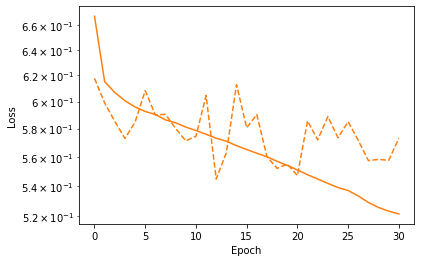

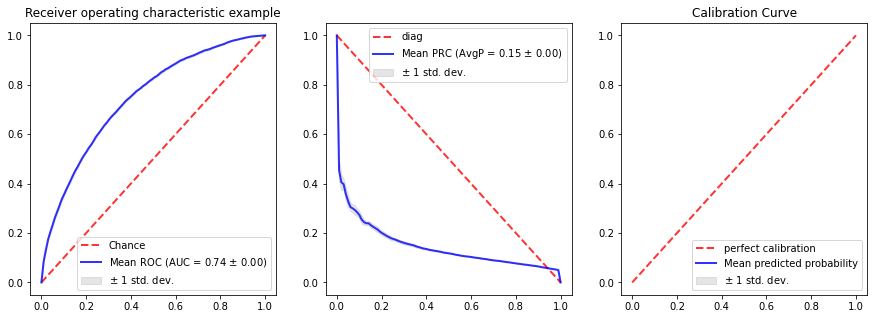

In [72]:
tic = time.perf_counter()

EPOCHS = 100
BATCH_SIZE = 2000


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



neg, pos = np.bincount(df_label['outcomes_1year'])
weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}


model= tf.keras.models.clone_model(tuner.get_best_models(num_models=1)[0])
model.save_weights('model_DNN_initial_weights.h5')
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)


MODEL_NAME='FFDNNwithEMBandHPmnsSE'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]

make_dir_for_callback_obj(callback_list)

history=model.fit(
    [train_cat,train_num],
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callback_list,
    validation_data=([val_cat,val_num], val_label),
    verbose=0,
    class_weight=class_weight)
plot_loss(history, "Careful Bias", 1)


cv=ShuffleSplit(n_splits=5,test_size=.5)

plot_aucpr_aucroc_test_nn_mixed(model,(test[:,:data_cat_cols],test[:,data_cat_cols:]),test_label,cv,fit_params=None,callback_list=None)
toc = time.perf_counter()



  0%|                                                                                                                | 0/5 [00:00<?, ?it/s]

 20%|████████████████████▊                                                                                   | 1/5 [00:03<00:15,  3.77s/it]

Fold #0::  20%|██████████████████▊                                                                           | 1/5 [00:03<00:15,  3.77s/it]

you got it right




Fold #0::  40%|█████████████████████████████████████▌                                                        | 2/5 [00:07<00:10,  3.63s/it]

Fold #1::  40%|█████████████████████████████████████▌                                                        | 2/5 [00:07<00:10,  3.63s/it]

you got it right




Fold #1::  60%|████████████████████████████████████████████████████████▍                                     | 3/5 [00:11<00:07,  3.74s/it]

Fold #2::  60%|████████████████████████████████████████████████████████▍                                     | 3/5 [00:11<00:07,  3.74s/it]

you got it right




Fold #2::  80%|███████████████████████████████████████████████████████████████████████████▏                  | 4/5 [00:14<00:03,  3.63s/it]

Fold #3::  80%|███████████████████████████████████████████████████████████████████████████▏                  | 4/5 [00:14<00:03,  3.63s/it]

you got it right




Fold #3:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]

Fold #4:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]

you got it right
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

AttributeError: 'Figure' object has no attribute 'save'

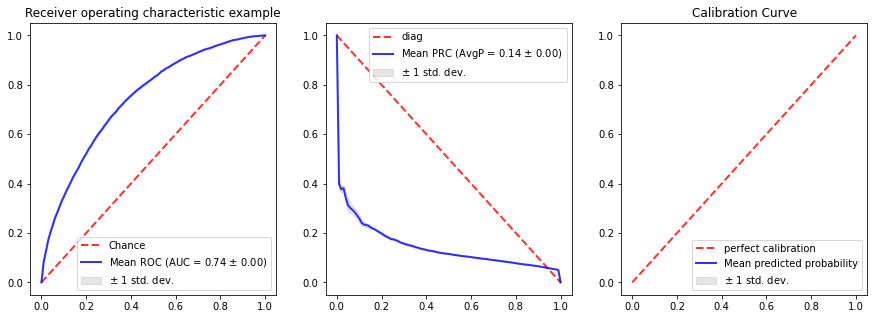

In [73]:
plot_aucpr_aucroc_test_nn_mixed(model,(test[:,:data_cat_cols],test[:,data_cat_cols:]),test_label,cv,fit_params=None,callback_list=None)


In [ ]:
results = model.evaluate((test[:,:data_cat_cols],test[:,data_cat_cols:]),test_label, batch_size=BATCH_SIZE )
for name, value in zip(model.metrics_names,results):
  print(name, ': ', value)
print()

plot_cm(test_label,  model.predict((test[:,:data_cat_cols],test[:,data_cat_cols:]),batch_size=BATCH_SIZE).ravel(),0.5)

In [327]:
log_dir_tb=os.path.join(log_dir,'TensorBoard','FFDNNwithEMBandHP_21_10_20_14_52')
    
# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir_tb, 'metadata.tsv'), "w") as f:
  for word,index in word_index_dict.items():
    f.write("{},{}-{}\n".format(index,index,word.split(',')[0]))

# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(model.layers[1].get_weights()[0])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir_tb, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir_tb, config)

In [328]:
%reload_ext tensorboard

In [329]:
%tensorboard --logdir {log_dir_tb}

ERROR: Failed to start `tensorboard`: [Errno 13] Permission denied:
'tensorboard'

In [1068]:
!kill 57853

In [1031]:
index_word_dict[338]

'other substance abuse/dependency'

In [1030]:
index_word_dict

{0: 'Ethnicity_African',
 1: 'Ethnicity_Any other Asian background',
 2: 'Ethnicity_Any other Black background',
 3: 'Ethnicity_Any other mixed background',
 4: 'Ethnicity_Any other white background',
 5: 'Ethnicity_Asian or Asian British',
 6: 'Ethnicity_Bangladeshi',
 7: 'Ethnicity_Black or Black British',
 8: 'Ethnicity_British',
 9: 'Ethnicity_Caribbean',
 10: 'Ethnicity_Chinese',
 11: 'Ethnicity_Do not know',
 12: 'Ethnicity_Indian',
 13: 'Ethnicity_Irish',
 14: 'Ethnicity_Mixed',
 15: 'Ethnicity_Other ethnic group',
 16: 'Ethnicity_Pakistani',
 17: 'Ethnicity_Prefer not to answer',
 18: 'Ethnicity_White',
 19: 'Ethnicity_White and Asian',
 20: 'Ethnicity_White and Black African',
 21: 'Ethnicity_White and Black Caribbean',
 22: 'Household_inc_18,000 to 30,999',
 23: 'Household_inc_31,000 to 51,999',
 24: 'Household_inc_52,000 to 100,000',
 25: 'Household_inc_Do not know',
 26: 'Household_inc_Greater than 100,000',
 27: 'Household_inc_Less than 18,000',
 28: 'Household_inc_Prefer 

In [942]:
!rm -rf logs

# AE-DNN

In [ ]:
# split and shuffle 


train_df, test_df, train_label_df, test_label_df = train_test_split(df_input_stnd,df_label['outcomes_1year'], test_size=0.3)
train_df, val_df, train_label_df, val_label_df = train_test_split(train_df,train_label_df, test_size=0.2)


binary_cols=list(train_df.columns.difference(non_binary_cols))

train_num=np.array(train_df[non_binary_cols]).astype('float32')
train_cat=np.array(train_df[binary_cols]).astype('float32')
val_num=np.array(val_df[non_binary_cols]).astype('float32')
val_cat=np.array(val_df[binary_cols]).astype('float32')
train_label=np.array(train_label_df).astype('float32')
val_label=np.array(val_label_df).astype('float32')

test_num=np.array(test_df[non_binary_cols]).astype('float32')
test_cat=np.array(test_df[binary_cols]).astype('float32')

test_label=np.array(test_label_df).astype('float32')

In [45]:
latent_dim = 32

def make_stacked_autoencoder_hp(hp):
    class Autoencoder(keras.models.Model):
      def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        latent_dim = hp.Int('latent_dim', 
                                        min_value = 4, 
                                        max_value = 16, 
                                        step = 4,
                                        default=4)
        #latent_dim=3


        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            keras.Input(shape=train_cat.shape[1]),
            keras.layers.Dense(256, activation='sigmoid'),
            keras.layers.Dense(128, activation='sigmoid'),
            keras.layers.Dense(64, activation='sigmoid'),
            keras.layers.Dense(latent_dim, activation='sigmoid'),
        ])
        self.decoder = tf.keras.Sequential([
            keras.Input(shape=latent_dim),
            keras.layers.Dense(64, activation='sigmoid'),
            keras.layers.Dense(128, activation='sigmoid'),
            keras.layers.Dense(256, activation='sigmoid'),
          keras.layers.Dense(train_cat.shape[1], activation='sigmoid'),
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


    hp_learning_rate =hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    #hp_learning_rate=0.01

    model = Autoencoder(latent_dim)
    model.compile(optimizer=keras.optimizers.Adam(lr=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy())


    return model




"""model=make_stacked_autoencoder_hp()



model.fit(train_cat, train_cat,
                epochs=10,
                shuffle=True,
                validation_data=(val_cat, val_cat))

print(model.summary())"""

'model=make_stacked_autoencoder_hp()\n\n\n\nmodel.fit(train_cat, train_cat,\n                epochs=10,\n                shuffle=True,\n                validation_data=(val_cat, val_cat))\n\nprint(model.summary())'

In [ ]:
def make_dir_for_callback_obj(callback_list):
    for callbackobj in callback_list:
        if  isinstance(callbackobj,tf.keras.callbacks.CSVLogger):
            dir_path=''
            for sub_dir in callbackobj.filename.split('/')[:-1]:
                dir_path=os.path.join(dir_path,sub_dir)
            print(dir_path)
                

            csv_file_name=callbackobj.filename.split('/')[-1]
            try:
                os.makedirs(dir_path)
            except FileExistsError:
                pass
                
    return

In [47]:
MODEL_NAME='hyper_DNN_SAE'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True),
              ]


make_dir_for_callback_obj(callback_list)




tuner = kt.tuners.bayesian.BayesianOptimization(
    make_stacked_autoencoder_hp,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=10,
    executions_per_trial=3,
    project_name=MODEL_NAME,
    directory=os.path.join(log_dir,'kt',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))))


tuner.search(train_cat, train_cat, epochs = 50, 
             validation_data = (val_cat, val_cat), 
             callbacks = callback_list,
            verbose=1,
             batch_size=5*BATCH_SIZE)

Trial 10 Complete [00h 01m 28s]
val_loss: 58.55363464355469

Best val_loss So Far: 58.44294993082682
Total elapsed time: 00h 19m 14s
INFO:tensorflow:Oracle triggered exit


In [48]:
tuner.results_summary()

Results summary
Results in logs/kt/hyper_DNN_SAE_21_11_02_18_17/hyper_DNN_SAE
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 8
Score: 58.44294993082682
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 8
Score: 58.55363464355469
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 8
Score: 58.576446533203125
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 4
Score: 58.57667541503906
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 8
Score: 58.60792032877604
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 16
Score: 58.715536753336586
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 8
Score: 58.743455251057945
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 12
Score: 58.79641342163086
Trial summary
Hyperparameters:
learning_rate: 0.01
latent_dim: 4
Score: 59.049004872639976
Trial summary
Hyperparameters:
learning

In [49]:
tuner.get_best_hyperparameters()[0].get('learning_rate')

0.01

In [61]:
tic = time.perf_counter()

EPOCHS = 100
BATCH_SIZE = 2000


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



#model= tf.keras.models.clone_model(tuner.get_best_models(num_models=1)[0])
model=tuner.get_best_models(num_models=1)[0]  #tf.Keras.Model subclass can't be cloned https://github.com/tensorflow/tensorflow/issues/47048

model.save_weights('model_AE_initial_weights.h5')
model.compile(
    optimizer=keras.optimizers.Adam(lr=tuner.get_best_hyperparameters()[0].get('learning_rate')),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)


MODEL_NAME='AEwithHP'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20,
    mode='min',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True)
              ]

make_dir_for_callback_obj(callback_list)

history=model.fit(
    train_cat, 
    train_cat,
    batch_size=BATCH_SIZE,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=callback_list,
    validation_data=(val_cat, val_cat),
    verbose=0,
    class_weight=class_weight)
plot_loss(history, "Careful Bias", 1)


toc = time.perf_counter()

logs/csvLogs


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[0] = 8 is not in [0, 2)
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
	 [[assert_greater_equal_4/Assert/AssertGuard/else/_113/assert_greater_equal_4/Assert/AssertGuard/Assert/data_2/_282]]
  (1) Invalid argument:  indices[0] = 8 is not in [0, 2)
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_192239]

Function call stack:
train_function -> train_function


In [ ]:
model.summary()

In [ ]:
def make_stacked_autoencoder():
    class Autoencoder(keras.models.Model):
      def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        


        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            keras.Input(shape=train_cat.shape[1]),
            keras.layers.Dense(256, activation='sigmoid'),
            keras.layers.Dense(128, activation='sigmoid'),
            keras.layers.Dense(64, activation='sigmoid'),
            keras.layers.Dense(latent_dim, activation='sigmoid'),
        ])
        self.decoder = tf.keras.Sequential([
            keras.Input(shape=latent_dim),
            keras.layers.Dense(64, activation='sigmoid'),
            keras.layers.Dense(128, activation='sigmoid'),
            keras.layers.Dense(256, activation='sigmoid'),
          keras.layers.Dense(train_cat.shape[1], activation='sigmoid'),
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    latent_dim=8

    hp_learning_rate=0.01

    model = Autoencoder(latent_dim)
    model.compile(optimizer=keras.optimizers.Adam(lr=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"))


    return model

In [ ]:
model=make_stacked_autoencoder()

model.fit(train_cat, train_cat,
                epochs=30,
                shuffle=True,
          callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True),],
                validation_data=(val_cat, val_cat))

encoded_records = model.encoder(val_cat).numpy()
decoded_records = model.decoder(encoded_records).numpy()

In [ ]:
modelAE=model
a=805
print(test_cat[a])
print(encoded_records[a])
print((decoded_records[a]>0.5).astype(int))

In [ ]:
train=np.concatenate((train_num,model.encoder(train_cat).numpy().astype('float32')),axis=1)
#train_label
val=np.concatenate((val_num,model.encoder(val_cat).numpy().astype('float32')),axis=1)
#val_label
test=np.concatenate((test_num,model.encoder(test_cat).numpy().astype('float32')),axis=1)
#test_label

In [ ]:
train.shape

In [ ]:

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model_hp(hp, metrics=METRICS, input_shape=None, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential()
    model.add(keras.Input(shape=(train.shape[1],)))    #'num_layers',  'units_', 'dropout_','learning_rate'
    for i in range(hp.Int('num_layers',2,5)):
        model.add(keras.layers.Dense(hp.Int('units_'+str(i), 
                                        min_value = 32, 
                                        max_value = 256, 
                                        step = 32,
                                        default=32),
                                 activation='relu'))
        model.add(keras.layers.Dropout(hp.Float('dropout_'+str(i),
                    min_value=0.0,
                    max_value=0.4,
                    default=0.01,
                    step=0.01)))
    

    model.add(keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model




class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [ ]:
MODEL_NAME='hyper_AE_DNN_mnsEnv'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]

tic = time.perf_counter()

make_dir_for_callback_obj(callback_list)

tuner=kt.tuners.bayesian.BayesianOptimization(make_model_hp,
                     objective = kt.Objective("val_auc", direction="max"), 
                     max_trials=10,
                     seed = 42,
                     executions_per_trial=3,
                     directory = 'logs/kt/21_11_3_AEDNN_mnsEnv')

tuner.search(train, train_label, epochs = 50, 
             validation_data = (val, val_label), 
             callbacks = callback_list,
            verbose=0)

toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))

In [57]:
tuner.get_best_models(num_models=1)[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                1920      
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8

In [58]:
tuner.results_summary()

Results summary
Results in logs/kt/21_11_3_AEDNN_mnsEnv/untitled_project
Showing 10 best trials
Objective(name='val_auc', direction='max')
Trial summary
Hyperparameters:
num_layers: 4
units_0: 96
dropout_0: 0.0
units_1: 256
dropout_1: 0.4
learning_rate: 0.0001
units_2: 32
dropout_2: 0.0
units_3: 256
dropout_3: 0.0
units_4: 192
dropout_4: 0.32
Score: 0.7061975995699564
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
dropout_0: 0.0
units_1: 256
dropout_1: 0.4
learning_rate: 0.0001
units_2: 32
dropout_2: 0.0
units_3: 256
dropout_3: 0.0
units_4: 32
dropout_4: 0.01
Score: 0.7061904072761536
Trial summary
Hyperparameters:
num_layers: 5
units_0: 32
dropout_0: 0.0
units_1: 256
dropout_1: 0.4
learning_rate: 0.0001
units_2: 32
dropout_2: 0.24
units_3: 256
dropout_3: 0.0
units_4: 256
dropout_4: 0.0
Score: 0.7058044672012329
Trial summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout_0: 0.0
units_1: 256
dropout_1: 0.32
learning_rate: 0.0001
units_2: 32
dropout_2: 0.0
units_3: 256
dr

In [59]:
tuner.get_best_hyperparameters()[0].get('learning_rate')

0.0001

logs/csvLogs


2021-11-03 22:34:47.310450: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-03 22:34:47.310485: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-03 22:34:47.310794: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-03 22:34:47.310819: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-11-03 22:34:49.163351: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-11-03 22:34:49.163386: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-11-03 22:34:49.163583: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping



Fold #0::  20%|█████████████████████████                                                                                                    | 1/5 [00:03<00:12,  3.06s/it]

you got it right



Fold #1::  40%|██████████████████████████████████████████████████                                                                           | 2/5 [00:07<00:11,  3.84s/it]

you got it right



Fold #2::  60%|███████████████████████████████████████████████████████████████████████████                                                  | 3/5 [00:13<00:09,  4.77s/it]

you got it right



Fold #3::  80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4/5 [00:18<00:04,  4.91s/it]

you got it right



Fold #4:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  5.19s/it]

you got it right
[[0.00576369 0.00432277 0.01010101 0.00288184 0.01152738 0.01010101
  0.00576369 0.00720461 0.01154401 0.01440922 0.00864553 0.01443001
  0.01152738 0.00432277 0.01154401 0.01585014 0.00864553 0.01154401
  0.01008646 0.01873199 0.01875902 0.02017291 0.01440922 0.02597403
  0.01440922 0.01440922 0.01010101 0.0259366  0.02161383 0.02453102
  0.03170029 0.02737752 0.02308802 0.0259366  0.02737752 0.02741703
  0.02449568 0.03025937 0.03463203 0.02737752 0.02737752 0.02308802
  0.03458213 0.03314121 0.03607504 0.0518732  0.0259366  0.03607504
  0.03746398 0.03896104 0.03314121 0.05043228 0.04184704 0.03602305
  0.04466859 0.02886003 0.03314121 0.04755043 0.03896104 0.05043228
  0.05763689 0.04473304 0.04322767 0.05331412 0.03463203 0.04610951
  0.06772334 0.06349206 0.05331412 0.07636888 0.06637807 0.07204611
  0.05907781 0.07647908 0.07492795 0.05907781 0.06782107 0.06051873
  0.0778098  0.07070707 0.07348703 0.07492795 0.08802309 0.06772334
  0.05619597 0.07359307 0.09077

AttributeError: 'Figure' object has no attribute 'save'

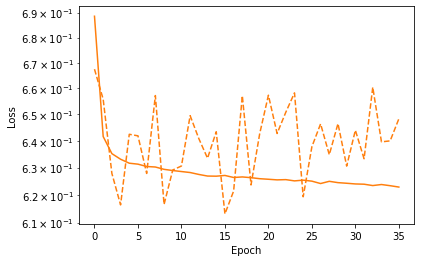

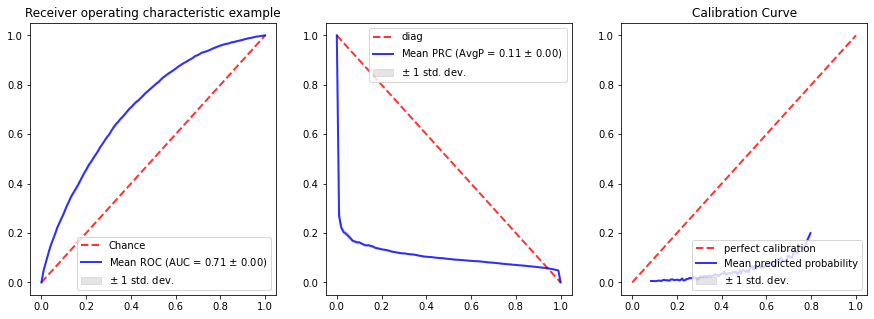

In [60]:
tic = time.perf_counter()

EPOCHS = 100
BATCH_SIZE = 2000


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



neg, pos = np.bincount(df_label['outcomes_1year'])
weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}


model= tf.keras.models.clone_model(tuner.get_best_models(num_models=1)[0])
model.save_weights('model_AEDNN_initial_weights.h5')
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)


MODEL_NAME='AEDNNwithHP_mns_env'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]

make_dir_for_callback_obj(callback_list)

history=model.fit(
    train,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callback_list,
    validation_data=(val, val_label),
    verbose=0,
    class_weight=class_weight)
plot_loss(history, "Careful Bias", 1)



cv=ShuffleSplit(n_splits=5,test_size=.5)

plot_aucpr_aucroc_test_nn(model,test,test_label,cv,fit_params=None,callback_list=None)
toc = time.perf_counter()

In [ ]:
plot_loss(history, "Careful Bias", 1)



cv=ShuffleSplit(n_splits=5,test_size=.5)

plot_aucpr_aucroc_test_nn(model,test,test_label,cv,fit_params=None,callback_list=None)
toc = time.perf_counter()

In [ ]:
results = model.evaluate(test,test_label, batch_size=BATCH_SIZE )
for name, value in zip(model.metrics_names,results):
  print(name, ': ', value)
print()

plot_cm(test_label, model.predict(test,batch_size=BATCH_SIZE),0.7)

In [ ]:
!conda info